In [4]:
#import libraries

# from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim


from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount("/gdrive")
%cd "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro"

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro


In [5]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [6]:
#import the data and filter the signals
# This could be change depending if you download or not the data

ECG_folder = "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/1_batch_extracted"
ECG_folder_2batch = "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/2_batch_extracted"


tabular_data = pd.read_excel("/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(r"/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)



Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [7]:
print(f"Number of positive: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% of positive: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

Number of positive: 360
% of positive: 68.44%


In [8]:
# Function to extract segment

def segment_ecg(signal, tabular_data, segment_length=5000):

    segments = np.zeros((signal.shape[0], segment_length, signal.shape[2]))
    index = 0
    for i in range(signal.shape[0]):

      start = 0 # we take the start at the middle or elsewhere
      end = start + segment_length
      segments[index, :, :] = signal[i, start:end, :]
      index += 1

    return segments, tabular_data

In [9]:
# ECG signals only
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        # PyTorch Conv1d wants: (Batch Size, Channels, Length)
        # Data were (N, 5000, 12), we tranform them in (N, 12, 5000)
        if signals.shape[1] > signals.shape[2]:
             self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        else:
             self.signals = torch.tensor(signals, dtype=torch.float32)

        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ritorna solo Segnale ed Etichetta
        return self.signals[idx], self.labels[idx]

# Modello 1

In [14]:
class Simple1DCNN(nn.Module):
    def __init__(self, num_leads=12):
        super(Simple1DCNN, self).__init__()

        # Input: [Batch, 12, 5000]

        # --- BLOCCO 1: 12 -> 32 ---
        self.conv1 = nn.Conv1d(num_leads, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2) # Output: 2500

        # --- BLOCCO 2: 32 -> 64 ---
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2) # Output: 1250

        # --- BLOCCO 3: 64 -> 128 ---
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2) # Output: 625

        # --- BLOCCO 4: 128 -> 256 ---
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.act4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(2) # Output: 312

        # --- BLOCCO 5: 256 -> 256 ---
        self.conv5 = nn.Conv1d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm1d(256)
        self.act5 = nn.ReLU()
        self.pool5 = nn.MaxPool1d(2) # Output: 156

        # --- BLOCCO 6: 256 -> 512 ---
        self.conv6 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.act6 = nn.ReLU()
        self.pool6 = nn.MaxPool1d(2) # Output: 78

        # --- BLOCCO 7 (Extra Pooling): Solo riduzione dimensionale ---
        # Non aggiungiamo convoluzioni per non aumentare i canali,
        # ma dimezziamo ancora il tempo per gestire i 5000 punti iniziali.
        self.pool7 = nn.MaxPool1d(2) # Output: 39 punti

        # --- CLASSIFICATORE ---
        # Calcolo dimensione: 512 canali * 39 punti temporali = 19.968 features
        # Questo numero è gestibile e simile alla versione precedente (che aveva 2500 in input e 6 blocchi)
        self.fc1 = nn.Linear(512 * 39, 128)
        self.act_fc = nn.ReLU()
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Passaggio attraverso i 6 blocchi conv
        x = self.pool1(self.act1(self.bn1(self.conv1(x))))
        x = self.pool2(self.act2(self.bn2(self.conv2(x))))
        x = self.pool3(self.act3(self.bn3(self.conv3(x))))
        x = self.pool4(self.act4(self.bn4(self.conv4(x))))
        x = self.pool5(self.act5(self.bn5(self.conv5(x))))
        x = self.pool6(self.act6(self.bn6(self.conv6(x))))

        # 7° Pooling extra
        x = self.pool7(x)

        # Flatten: [Batch, 512, 39] -> [Batch, 19968]
        x = x.view(x.size(0), -1)

        x = self.act_fc(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [21]:
#implementation of the ten fold cross-validation

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    ##################### correction to class imbalance
    # Creazione Dataset
    train_dataset = ECGDataset(ecg_train_segments, Y_train)
    test_dataset = ECGDataset(ecg_test_segments, Y_test)

    # --- INIZIO BILANCIAMENTO CLASSI (WeightedRandomSampler) ---
    from torch.utils.data import WeightedRandomSampler

    # Recuperiamo le etichette come array di interi
    targets = Y_train.values.astype(int)

    # Contiamo quanti campioni ci sono per ogni classe (0 e 1)
    class_counts = np.bincount(targets)

    # Calcoliamo il peso per ogni classe (inverso della frequenza)
    # Esempio: se ho 10 sani e 100 malati, il peso dei sani sarà 1/10 e dei malati 1/100
    class_weights = 1. / class_counts

    # Assegniamo il peso corrispondente a ogni singolo esempio del dataset di training
    samples_weights = class_weights[targets]

    # Creiamo il Sampler
    sampler = WeightedRandomSampler(
        weights=torch.from_numpy(samples_weights).double(),
        num_samples=len(samples_weights),
        replacement=True
    )

    # DataLoader:
    # NOTA BENE: Con il sampler, DEVI togliere 'shuffle=True' (lo fa già il sampler)
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    # end balancing

    # Inizializzazione del Modello (Simple1DCNN)
    # Nota: Assicurati di usare le parentesi () per istanziare la classe!
    model = Simple1DCNN(num_leads=12).to(device)

    # Criterio e Ottimizzatore
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ## Variabili early-stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for signals_ecg, labels in train_loader:
            model.train()
            # Rimosso tabular.to(device)
            signals_ecg, labels = signals_ecg.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passiamo solo il segnale al modello
            outputs = model(signals_ecg)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for signals_ecg, labels in test_loader:
                # Rimosso tabular.to(device)
                signals_ecg, labels = signals_ecg.to(device), labels.to(device)

                # Passiamo solo il segnale
                outputs = model(signals_ecg)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

            ## early stopping
            if test_loss < best_test_loss:
                 best_test_loss = test_loss
                 trigger_times = 0
                 # Salviamo i pesi del modello attuale perché è il migliore finora
                 torch.save(model.state_dict(), 'best_model_fold.pth')
            else:
                 trigger_times += 1
                 # print(f"Patience: {trigger_times}/{patience}") # Decommenta se vuoi vedere il contatore

                 if trigger_times >= patience:
                     print(f"Early stopping attivato all'epoca {epoch+1}!")
                     # IMPORTANTE: Prima di uscire, ricarichiamo i pesi migliori salvati
                     # Altrimenti il modello rimarrebbe quello "peggiorato" dell'ultima epoca
                     model.load_state_dict(torch.load('best_model_fold.pth'))
                     break # Esce dal ciclo "for epoch" e passa al prossimo Fold

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])



print(f"Accuracy: {accuracy_list_all_folds}")
print(f"Accuracy Train: {accuracy_list_all_folds_train}")
print(f"F1 Score: {f1_list_all_folds}")
print(f"F1 Score Train: {f1_list_all_folds_train}")
print(f"Sensitivity: {sensitivity_list_all_folds}")
print(f"Sensitivity Train: {sensitivity_list_all_folds_train}")
print(f"Specificity: {specificity_list_all_folds}")
print(f"Specificity Train: {specificity_list_all_folds_train}")
print(f"AUC: {auc_score_list_all_folds}")
print(f"AUC Train: {auc_score_list_all_folds_train}")
print(f"Test Loss: {test_loss_max}")
print(f"Train Loss: {train_loss_max}")
print(f"Epochs: {epochs_all_fold}")

  2%|▏         | 1/50 [00:00<00:34,  1.40it/s]



Epoch 1, Train Loss: 1.9470615943272909
Test loss: 0.8711168766021729, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


Epoch 2, Train Loss: 0.834876024723053
Test loss: 0.7610434889793396, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:01<00:36,  1.33it/s]



Epoch 3, Train Loss: 0.7002894282341003
Test loss: 0.6678003072738647, Accuracy: 35.85% F1 Score: 0.1053, Sensitivity: 0.0556, Specificity: 1.0000, AUC: 0.5278
TP: 2, FP: 0, TN: 17, FN: 34


  6%|▌         | 3/50 [00:02<00:44,  1.05it/s]



Epoch 4, Train Loss: 0.6602629502614339


  8%|▊         | 4/50 [00:03<00:41,  1.12it/s]

Test loss: 0.7315709590911865, Accuracy: 32.08% F1 Score: 0.0526, Sensitivity: 0.0278, Specificity: 0.9412, AUC: 0.4845
TP: 1, FP: 1, TN: 16, FN: 35


 10%|█         | 5/50 [00:04<00:37,  1.21it/s]



Epoch 5, Train Loss: 0.6489468892415364
Test loss: 0.7617708146572113, Accuracy: 33.96% F1 Score: 0.1463, Sensitivity: 0.0833, Specificity: 0.8824, AUC: 0.4828
TP: 3, FP: 2, TN: 15, FN: 33


 12%|█▏        | 6/50 [00:04<00:34,  1.27it/s]



Epoch 6, Train Loss: 0.6396153450012207
Test loss: 0.7297940850257874, Accuracy: 32.08% F1 Score: 0.1429, Sensitivity: 0.0833, Specificity: 0.8235, AUC: 0.4534
TP: 3, FP: 3, TN: 14, FN: 33


 14%|█▍        | 7/50 [00:05<00:32,  1.31it/s]



Epoch 7, Train Loss: 0.6017090876897176
Test loss: 0.8357293903827667, Accuracy: 43.40% F1 Score: 0.5161, Sensitivity: 0.4444, Specificity: 0.4118, AUC: 0.4281
TP: 16, FP: 10, TN: 7, FN: 20


 14%|█▍        | 7/50 [00:06<00:37,  1.14it/s]



Epoch 8, Train Loss: 0.5723308285077413
Test loss: 0.6777854263782501, Accuracy: 49.06% F1 Score: 0.5970, Sensitivity: 0.5556, Specificity: 0.3529, AUC: 0.4542
TP: 20, FP: 11, TN: 6, FN: 16
Early stopping attivato all'epoca 8!



  2%|▏         | 1/50 [00:00<00:26,  1.87it/s]



Epoch 1, Train Loss: 1.9873149553934732
Test loss: 0.626032680273056, Accuracy: 33.96% F1 Score: 0.1026, Sensitivity: 0.0556, Specificity: 0.9412, AUC: 0.4984
TP: 2, FP: 1, TN: 16, FN: 34


  4%|▍         | 2/50 [00:01<00:24,  1.95it/s]



Epoch 2, Train Loss: 0.7517903486887614
Test loss: 0.6316559016704559, Accuracy: 32.08% F1 Score: 0.1000, Sensitivity: 0.0556, Specificity: 0.8824, AUC: 0.4690
TP: 2, FP: 2, TN: 15, FN: 34


  6%|▌         | 3/50 [00:01<00:24,  1.91it/s]



Epoch 3, Train Loss: 0.6522759675979615
Test loss: 0.6046054363250732, Accuracy: 33.96% F1 Score: 0.1026, Sensitivity: 0.0556, Specificity: 0.9412, AUC: 0.4984
TP: 2, FP: 1, TN: 16, FN: 34


  8%|▊         | 4/50 [00:02<00:24,  1.88it/s]



Epoch 4, Train Loss: 0.5896706740061443
Test loss: 0.5645047128200531, Accuracy: 67.92% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 27, FP: 8, TN: 9, FN: 9


 10%|█         | 5/50 [00:02<00:23,  1.93it/s]



Epoch 5, Train Loss: 0.5619270026683807
Test loss: 0.5771942138671875, Accuracy: 58.49% F1 Score: 0.5926, Sensitivity: 0.4444, Specificity: 0.8824, AUC: 0.6634
TP: 16, FP: 2, TN: 15, FN: 20


 12%|█▏        | 6/50 [00:03<00:22,  1.96it/s]



Epoch 6, Train Loss: 0.5622804522514343
Test loss: 0.6412925124168396, Accuracy: 56.60% F1 Score: 0.5660, Sensitivity: 0.4167, Specificity: 0.8824, AUC: 0.6495
TP: 15, FP: 2, TN: 15, FN: 21


 14%|█▍        | 7/50 [00:03<00:21,  1.98it/s]



Epoch 7, Train Loss: 0.534925123055776
Test loss: 0.6411362886428833, Accuracy: 52.83% F1 Score: 0.4681, Sensitivity: 0.3056, Specificity: 1.0000, AUC: 0.6528
TP: 11, FP: 0, TN: 17, FN: 25


 16%|█▌        | 8/50 [00:04<00:21,  1.99it/s]



Epoch 8, Train Loss: 0.48471317291259763
Test loss: 1.112149953842163, Accuracy: 39.62% F1 Score: 0.2727, Sensitivity: 0.1667, Specificity: 0.8824, AUC: 0.5245
TP: 6, FP: 2, TN: 15, FN: 30


 18%|█▊        | 9/50 [00:04<00:21,  1.94it/s]



Epoch 9, Train Loss: 0.47765135765075684
Test loss: 0.5541242957115173, Accuracy: 67.92% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7647, AUC: 0.7018
TP: 23, FP: 4, TN: 13, FN: 13


 20%|██        | 10/50 [00:05<00:20,  1.96it/s]



Epoch 10, Train Loss: 0.43157432675361634
Test loss: 0.6136972904205322, Accuracy: 67.92% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5882, AUC: 0.6552
TP: 26, FP: 7, TN: 10, FN: 10


 22%|██▏       | 11/50 [00:05<00:19,  1.98it/s]



Epoch 11, Train Loss: 0.4103536685307821
Test loss: 0.6487712264060974, Accuracy: 64.15% F1 Score: 0.6885, Sensitivity: 0.5833, Specificity: 0.7647, AUC: 0.6740
TP: 21, FP: 4, TN: 13, FN: 15


 24%|██▍       | 12/50 [00:06<00:19,  1.99it/s]



Epoch 12, Train Loss: 0.38591031233469647
Test loss: 1.1920886635780334, Accuracy: 52.83% F1 Score: 0.5763, Sensitivity: 0.4722, Specificity: 0.6471, AUC: 0.5596
TP: 17, FP: 6, TN: 11, FN: 19


 26%|██▌       | 13/50 [00:06<00:18,  2.00it/s]



Epoch 13, Train Loss: 0.4222684562206268
Test loss: 0.8047356307506561, Accuracy: 54.72% F1 Score: 0.5714, Sensitivity: 0.4444, Specificity: 0.7647, AUC: 0.6046
TP: 16, FP: 4, TN: 13, FN: 20


 26%|██▌       | 13/50 [00:07<00:20,  1.82it/s]



Epoch 14, Train Loss: 0.3074362208445867
Test loss: 0.9200523793697357, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:26,  1.87it/s]



Epoch 1, Train Loss: 1.6601163268089294
Test loss: 0.6615157127380371, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:01<00:24,  1.95it/s]



Epoch 2, Train Loss: 0.7461522102355957
Test loss: 0.6769920587539673, Accuracy: 33.96% F1 Score: 0.0541, Sensitivity: 0.0278, Specificity: 1.0000, AUC: 0.5139
TP: 1, FP: 0, TN: 17, FN: 35


  6%|▌         | 3/50 [00:01<00:26,  1.80it/s]



Epoch 3, Train Loss: 0.6922348141670227
Test loss: 0.6396563351154327, Accuracy: 37.74% F1 Score: 0.1538, Sensitivity: 0.0833, Specificity: 1.0000, AUC: 0.5417
TP: 3, FP: 0, TN: 17, FN: 33


  8%|▊         | 4/50 [00:02<00:26,  1.72it/s]



Epoch 4, Train Loss: 0.6720840017000834
Test loss: 0.6329964697360992, Accuracy: 37.74% F1 Score: 0.1951, Sensitivity: 0.1111, Specificity: 0.9412, AUC: 0.5261
TP: 4, FP: 1, TN: 16, FN: 32


 10%|█         | 5/50 [00:02<00:25,  1.74it/s]



Epoch 5, Train Loss: 0.6613269209861755
Test loss: 0.6334815323352814, Accuracy: 39.62% F1 Score: 0.2000, Sensitivity: 0.1111, Specificity: 1.0000, AUC: 0.5556
TP: 4, FP: 0, TN: 17, FN: 32


 12%|█▏        | 6/50 [00:03<00:25,  1.75it/s]



Epoch 6, Train Loss: 0.6553650617599487
Test loss: 0.6387979984283447, Accuracy: 33.96% F1 Score: 0.0541, Sensitivity: 0.0278, Specificity: 1.0000, AUC: 0.5139
TP: 1, FP: 0, TN: 17, FN: 35


 14%|█▍        | 7/50 [00:03<00:24,  1.75it/s]



Epoch 7, Train Loss: 0.6279598434766134
Test loss: 0.6523343026638031, Accuracy: 41.51% F1 Score: 0.3404, Sensitivity: 0.2222, Specificity: 0.8235, AUC: 0.5229
TP: 8, FP: 3, TN: 14, FN: 28


 16%|█▌        | 8/50 [00:04<00:23,  1.80it/s]



Epoch 8, Train Loss: 0.6367073019345602
Test loss: 0.6652471423149109, Accuracy: 37.74% F1 Score: 0.2979, Sensitivity: 0.1944, Specificity: 0.7647, AUC: 0.4796
TP: 7, FP: 4, TN: 13, FN: 29


 18%|█▊        | 9/50 [00:05<00:26,  1.56it/s]



Epoch 9, Train Loss: 0.6048985878626506
Test loss: 0.6021600663661957, Accuracy: 56.60% F1 Score: 0.6230, Sensitivity: 0.5278, Specificity: 0.6471, AUC: 0.5874
TP: 19, FP: 6, TN: 11, FN: 17


Epoch 10, Train Loss: 0.6386393745740254


 20%|██        | 10/50 [00:06<00:27,  1.44it/s]

Test loss: 0.6712523996829987, Accuracy: 33.96% F1 Score: 0.1026, Sensitivity: 0.0556, Specificity: 0.9412, AUC: 0.4984
TP: 2, FP: 1, TN: 16, FN: 34


 22%|██▏       | 11/50 [00:06<00:25,  1.50it/s]



Epoch 11, Train Loss: 0.58857102394104
Test loss: 0.5942395925521851, Accuracy: 64.15% F1 Score: 0.7246, Sensitivity: 0.6944, Specificity: 0.5294, AUC: 0.6119
TP: 25, FP: 8, TN: 9, FN: 11


 24%|██▍       | 12/50 [00:07<00:23,  1.63it/s]



Epoch 12, Train Loss: 0.5607526918252309
Test loss: 0.8067563772201538, Accuracy: 45.28% F1 Score: 0.4082, Sensitivity: 0.2778, Specificity: 0.8235, AUC: 0.5507
TP: 10, FP: 3, TN: 14, FN: 26


 26%|██▌       | 13/50 [00:07<00:21,  1.73it/s]



Epoch 13, Train Loss: 0.5657295266787211
Test loss: 0.6945378482341766, Accuracy: 50.94% F1 Score: 0.5667, Sensitivity: 0.4722, Specificity: 0.5882, AUC: 0.5302
TP: 17, FP: 7, TN: 10, FN: 19


 28%|██▊       | 14/50 [00:08<00:19,  1.81it/s]



Epoch 14, Train Loss: 0.5374813000361125
Test loss: 0.7336442172527313, Accuracy: 52.83% F1 Score: 0.5902, Sensitivity: 0.5000, Specificity: 0.5882, AUC: 0.5441
TP: 18, FP: 7, TN: 10, FN: 18


 30%|███       | 15/50 [00:08<00:18,  1.87it/s]



Epoch 15, Train Loss: 0.5047127226988475
Test loss: 0.7831927537918091, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 30%|███       | 15/50 [00:09<00:21,  1.62it/s]



Epoch 16, Train Loss: 0.4379281759262085
Test loss: 0.8180899918079376, Accuracy: 67.92% F1 Score: 0.7792, Sensitivity: 0.8333, Specificity: 0.3529, AUC: 0.5931
TP: 30, FP: 11, TN: 6, FN: 6
Early stopping attivato all'epoca 16!



  2%|▏         | 1/50 [00:00<00:26,  1.87it/s]



Epoch 1, Train Loss: 3.463889225323995
Test loss: 0.6295901834964752, Accuracy: 67.92% F1 Score: 0.8046, Sensitivity: 0.9722, Specificity: 0.0588, AUC: 0.5155
TP: 35, FP: 16, TN: 1, FN: 1


  4%|▍         | 2/50 [00:01<00:24,  1.96it/s]



Epoch 2, Train Loss: 0.7678931434949239
Test loss: 0.7081157565116882, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  6%|▌         | 3/50 [00:01<00:24,  1.92it/s]



Epoch 3, Train Loss: 0.5839542806148529
Test loss: 0.6002420485019684, Accuracy: 71.70% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1765, AUC: 0.5743
TP: 35, FP: 14, TN: 3, FN: 1


  8%|▊         | 4/50 [00:02<00:23,  1.96it/s]



Epoch 4, Train Loss: 0.6068157494068146
Test loss: 0.7651110291481018, Accuracy: 47.17% F1 Score: 0.4400, Sensitivity: 0.3056, Specificity: 0.8235, AUC: 0.5645
TP: 11, FP: 3, TN: 14, FN: 25


 10%|█         | 5/50 [00:02<00:22,  1.98it/s]



Epoch 5, Train Loss: 0.5917135496934255
Test loss: 0.8809027075767517, Accuracy: 33.96% F1 Score: 0.1026, Sensitivity: 0.0556, Specificity: 0.9412, AUC: 0.4984
TP: 2, FP: 1, TN: 16, FN: 34


 12%|█▏        | 6/50 [00:03<00:22,  1.99it/s]



Epoch 6, Train Loss: 0.5664274613062541
Test loss: 0.6935392320156097, Accuracy: 47.17% F1 Score: 0.4400, Sensitivity: 0.3056, Specificity: 0.8235, AUC: 0.5645
TP: 11, FP: 3, TN: 14, FN: 25


 14%|█▍        | 7/50 [00:03<00:22,  1.95it/s]



Epoch 7, Train Loss: 0.514819864432017
Test loss: 0.5769165009260178, Accuracy: 60.38% F1 Score: 0.6182, Sensitivity: 0.4722, Specificity: 0.8824, AUC: 0.6773
TP: 17, FP: 2, TN: 15, FN: 19


 16%|█▌        | 8/50 [00:04<00:21,  1.96it/s]



Epoch 8, Train Loss: 0.45617263118426005
Test loss: 0.6180883347988129, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 18%|█▊        | 9/50 [00:04<00:20,  1.98it/s]



Epoch 9, Train Loss: 0.3888401329517365
Test loss: 0.9637526273727417, Accuracy: 66.04% F1 Score: 0.7750, Sensitivity: 0.8611, Specificity: 0.2353, AUC: 0.5482
TP: 31, FP: 13, TN: 4, FN: 5


 20%|██        | 10/50 [00:05<00:21,  1.89it/s]



Epoch 10, Train Loss: 0.4287918031215668
Test loss: 0.8850139379501343, Accuracy: 56.60% F1 Score: 0.6230, Sensitivity: 0.5278, Specificity: 0.6471, AUC: 0.5874
TP: 19, FP: 6, TN: 11, FN: 17


 22%|██▏       | 11/50 [00:05<00:20,  1.87it/s]



Epoch 11, Train Loss: 0.37272720634937284
Test loss: 0.8918695449829102, Accuracy: 60.38% F1 Score: 0.6441, Sensitivity: 0.5278, Specificity: 0.7647, AUC: 0.6462
TP: 19, FP: 4, TN: 13, FN: 17


 22%|██▏       | 11/50 [00:06<00:22,  1.74it/s]



Epoch 12, Train Loss: 0.4197113831837972
Test loss: 0.7214738428592682, Accuracy: 66.04% F1 Score: 0.7097, Sensitivity: 0.6111, Specificity: 0.7647, AUC: 0.6879
TP: 22, FP: 4, TN: 13, FN: 14
Early stopping attivato all'epoca 12!



  2%|▏         | 1/50 [00:00<00:30,  1.59it/s]



Epoch 1, Train Loss: 2.1090227484703066
Test loss: 0.7615810632705688, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:01<00:27,  1.73it/s]



Epoch 2, Train Loss: 0.8644411126772563
Test loss: 0.7249504029750824, Accuracy: 32.08% F1 Score: 0.0526, Sensitivity: 0.0278, Specificity: 0.9412, AUC: 0.4845
TP: 1, FP: 1, TN: 16, FN: 35


  6%|▌         | 3/50 [00:01<00:26,  1.77it/s]



Epoch 3, Train Loss: 0.6999417662620544
Test loss: 0.6918136775493622, Accuracy: 30.19% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 0.9412, AUC: 0.4706
TP: 0, FP: 1, TN: 16, FN: 36


  8%|▊         | 4/50 [00:02<00:24,  1.86it/s]



Epoch 4, Train Loss: 0.6181519786516826
Test loss: 0.7311552166938782, Accuracy: 30.19% F1 Score: 0.0976, Sensitivity: 0.0556, Specificity: 0.8235, AUC: 0.4395
TP: 2, FP: 3, TN: 14, FN: 34


 10%|█         | 5/50 [00:02<00:26,  1.68it/s]



Epoch 5, Train Loss: 0.5903701106707255
Test loss: 0.8176788687705994, Accuracy: 30.19% F1 Score: 0.0513, Sensitivity: 0.0278, Specificity: 0.8824, AUC: 0.4551
TP: 1, FP: 2, TN: 15, FN: 35


 12%|█▏        | 6/50 [00:03<00:25,  1.71it/s]



Epoch 6, Train Loss: 0.6118001103401184
Test loss: 0.6918027997016907, Accuracy: 37.74% F1 Score: 0.3265, Sensitivity: 0.2222, Specificity: 0.7059, AUC: 0.4641
TP: 8, FP: 5, TN: 12, FN: 28


 14%|█▍        | 7/50 [00:03<00:23,  1.80it/s]



Epoch 7, Train Loss: 0.6017390211423238
Test loss: 0.8184793889522552, Accuracy: 33.96% F1 Score: 0.1463, Sensitivity: 0.0833, Specificity: 0.8824, AUC: 0.4828
TP: 3, FP: 2, TN: 15, FN: 33


 16%|█▌        | 8/50 [00:04<00:23,  1.81it/s]



Epoch 8, Train Loss: 0.5536431849002839
Test loss: 0.687539353966713, Accuracy: 64.15% F1 Score: 0.7595, Sensitivity: 0.8333, Specificity: 0.2353, AUC: 0.5343
TP: 30, FP: 13, TN: 4, FN: 6


 18%|█▊        | 9/50 [00:05<00:22,  1.82it/s]



Epoch 9, Train Loss: 0.5277950803438822
Test loss: 0.6866942942142487, Accuracy: 56.60% F1 Score: 0.6849, Sensitivity: 0.6944, Specificity: 0.2941, AUC: 0.4943
TP: 25, FP: 12, TN: 5, FN: 11


 20%|██        | 10/50 [00:05<00:21,  1.87it/s]



Epoch 10, Train Loss: 0.46703837712605795
Test loss: 0.7199845314025879, Accuracy: 60.38% F1 Score: 0.6866, Sensitivity: 0.6389, Specificity: 0.5294, AUC: 0.5842
TP: 23, FP: 8, TN: 9, FN: 13


 22%|██▏       | 11/50 [00:06<00:20,  1.92it/s]



Epoch 11, Train Loss: 0.5206218977769216
Test loss: 1.3945568799972534, Accuracy: 41.51% F1 Score: 0.2791, Sensitivity: 0.1667, Specificity: 0.9412, AUC: 0.5539
TP: 6, FP: 1, TN: 16, FN: 30


 24%|██▍       | 12/50 [00:06<00:19,  1.94it/s]



Epoch 12, Train Loss: 0.4579999327659607
Test loss: 0.8030614256858826, Accuracy: 62.26% F1 Score: 0.7297, Sensitivity: 0.7500, Specificity: 0.3529, AUC: 0.5515
TP: 27, FP: 11, TN: 6, FN: 9


 26%|██▌       | 13/50 [00:07<00:18,  1.97it/s]



Epoch 13, Train Loss: 0.4799244046211243
Test loss: 1.1360241174697876, Accuracy: 47.17% F1 Score: 0.4167, Sensitivity: 0.2778, Specificity: 0.8824, AUC: 0.5801
TP: 10, FP: 2, TN: 15, FN: 26


 26%|██▌       | 13/50 [00:07<00:21,  1.71it/s]



Epoch 14, Train Loss: 0.45752716064453125
Test loss: 1.1341355741024017, Accuracy: 52.83% F1 Score: 0.5455, Sensitivity: 0.4167, Specificity: 0.7647, AUC: 0.5907
TP: 15, FP: 4, TN: 13, FN: 21
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:26,  1.84it/s]



Epoch 1, Train Loss: 2.2861612995465594
Test loss: 0.6636328995227814, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:01<00:25,  1.92it/s]



Epoch 2, Train Loss: 0.9205297152201335
Test loss: 0.7958545088768005, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  6%|▌         | 3/50 [00:01<00:25,  1.88it/s]



Epoch 3, Train Loss: 0.6961477041244507
Test loss: 0.66261026263237, Accuracy: 32.08% F1 Score: 0.0526, Sensitivity: 0.0278, Specificity: 0.9412, AUC: 0.4845
TP: 1, FP: 1, TN: 16, FN: 35


  8%|▊         | 4/50 [00:02<00:23,  1.92it/s]



Epoch 4, Train Loss: 0.666513462861379
Test loss: 0.6738430261611938, Accuracy: 30.19% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 0.9412, AUC: 0.4706
TP: 0, FP: 1, TN: 16, FN: 36


 10%|█         | 5/50 [00:02<00:23,  1.91it/s]



Epoch 5, Train Loss: 0.6488107919692994
Test loss: 0.7027129530906677, Accuracy: 32.08% F1 Score: 0.1000, Sensitivity: 0.0556, Specificity: 0.8824, AUC: 0.4690
TP: 2, FP: 2, TN: 15, FN: 34


 12%|█▏        | 6/50 [00:03<00:23,  1.87it/s]



Epoch 6, Train Loss: 0.6258831222852071
Test loss: 0.6865035593509674, Accuracy: 37.74% F1 Score: 0.2326, Sensitivity: 0.1389, Specificity: 0.8824, AUC: 0.5106
TP: 5, FP: 2, TN: 15, FN: 31


 14%|█▍        | 7/50 [00:03<00:23,  1.85it/s]



Epoch 7, Train Loss: 0.6163820505142212
Test loss: 0.743436336517334, Accuracy: 32.08% F1 Score: 0.2800, Sensitivity: 0.1944, Specificity: 0.5882, AUC: 0.3913
TP: 7, FP: 7, TN: 10, FN: 29


 14%|█▍        | 7/50 [00:04<00:26,  1.61it/s]



Epoch 8, Train Loss: 0.6376242081324259
Test loss: 0.7448665201663971, Accuracy: 35.85% F1 Score: 0.2609, Sensitivity: 0.1667, Specificity: 0.7647, AUC: 0.4657
TP: 6, FP: 4, TN: 13, FN: 30
Early stopping attivato all'epoca 8!



  2%|▏         | 1/50 [00:00<00:29,  1.68it/s]



Epoch 1, Train Loss: 20.27659346262614
Test loss: 0.9833117425441742, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:01<00:25,  1.85it/s]



Epoch 2, Train Loss: 2.909981441497803
Test loss: 1.8819758296012878, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:25,  1.85it/s]



Epoch 3, Train Loss: 2.4302422563234964
Test loss: 0.8403483331203461, Accuracy: 71.15% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2500, AUC: 0.5833
TP: 33, FP: 12, TN: 4, FN: 3


  8%|▊         | 4/50 [00:02<00:24,  1.89it/s]



Epoch 4, Train Loss: 2.944584600130717
Test loss: 0.9206694066524506, Accuracy: 32.69% F1 Score: 0.1860, Sensitivity: 0.1111, Specificity: 0.8125, AUC: 0.4618
TP: 4, FP: 3, TN: 13, FN: 32


 10%|█         | 5/50 [00:02<00:24,  1.87it/s]



Epoch 5, Train Loss: 2.1693376819292705
Test loss: 0.6649347841739655, Accuracy: 34.62% F1 Score: 0.1500, Sensitivity: 0.0833, Specificity: 0.9375, AUC: 0.5104
TP: 3, FP: 1, TN: 15, FN: 33


 12%|█▏        | 6/50 [00:03<00:23,  1.91it/s]



Epoch 6, Train Loss: 1.3766407012939452
Test loss: 0.6902448236942291, Accuracy: 36.54% F1 Score: 0.2667, Sensitivity: 0.1667, Specificity: 0.8125, AUC: 0.4896
TP: 6, FP: 3, TN: 13, FN: 30


 14%|█▍        | 7/50 [00:03<00:22,  1.94it/s]



Epoch 7, Train Loss: 0.7063836296399434
Test loss: 0.6977573335170746, Accuracy: 32.69% F1 Score: 0.0541, Sensitivity: 0.0278, Specificity: 1.0000, AUC: 0.5139
TP: 1, FP: 0, TN: 16, FN: 35


 16%|█▌        | 8/50 [00:04<00:21,  1.95it/s]



Epoch 8, Train Loss: 0.6518856088320414
Test loss: 0.7355901598930359, Accuracy: 44.23% F1 Score: 0.4912, Sensitivity: 0.3889, Specificity: 0.5625, AUC: 0.4757
TP: 14, FP: 7, TN: 9, FN: 22


 18%|█▊        | 9/50 [00:04<00:20,  1.97it/s]



Epoch 9, Train Loss: 0.6421915411949157
Test loss: 0.7702957391738892, Accuracy: 50.00% F1 Score: 0.6579, Sensitivity: 0.6944, Specificity: 0.0625, AUC: 0.3785
TP: 25, FP: 15, TN: 1, FN: 11


 18%|█▊        | 9/50 [00:05<00:23,  1.72it/s]



Epoch 10, Train Loss: 0.6366577068964641
Test loss: 0.8238310515880585, Accuracy: 32.69% F1 Score: 0.1860, Sensitivity: 0.1111, Specificity: 0.8125, AUC: 0.4618
TP: 4, FP: 3, TN: 13, FN: 32
Early stopping attivato all'epoca 10!



  2%|▏         | 1/50 [00:00<00:27,  1.81it/s]



Epoch 1, Train Loss: 2.2098684986432393
Test loss: 0.694249302148819, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:01<00:26,  1.81it/s]



Epoch 2, Train Loss: 0.7698301990826925
Test loss: 0.6205913126468658, Accuracy: 57.69% F1 Score: 0.6857, Sensitivity: 0.6667, Specificity: 0.3750, AUC: 0.5208
TP: 24, FP: 10, TN: 6, FN: 12


  6%|▌         | 3/50 [00:01<00:25,  1.88it/s]



Epoch 3, Train Loss: 0.6528777837753296
Test loss: 0.7566468119621277, Accuracy: 25.00% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 0.8125, AUC: 0.4062
TP: 0, FP: 3, TN: 13, FN: 36


  8%|▊         | 4/50 [00:02<00:23,  1.92it/s]



Epoch 4, Train Loss: 0.6627855777740479
Test loss: 0.723525732755661, Accuracy: 26.92% F1 Score: 0.1739, Sensitivity: 0.1111, Specificity: 0.6250, AUC: 0.3681
TP: 4, FP: 6, TN: 10, FN: 32


 10%|█         | 5/50 [00:02<00:23,  1.95it/s]



Epoch 5, Train Loss: 0.6367710153261821
Test loss: 0.7931692004203796, Accuracy: 25.00% F1 Score: 0.0488, Sensitivity: 0.0278, Specificity: 0.7500, AUC: 0.3889
TP: 1, FP: 4, TN: 12, FN: 35


 12%|█▏        | 6/50 [00:03<00:22,  1.97it/s]



Epoch 6, Train Loss: 0.609098756313324
Test loss: 0.8505024313926697, Accuracy: 26.92% F1 Score: 0.0500, Sensitivity: 0.0278, Specificity: 0.8125, AUC: 0.4201
TP: 1, FP: 3, TN: 13, FN: 35


 12%|█▏        | 6/50 [00:03<00:26,  1.65it/s]



Epoch 7, Train Loss: 0.6606626669565837
Test loss: 0.7540515065193176, Accuracy: 25.00% F1 Score: 0.0488, Sensitivity: 0.0278, Specificity: 0.7500, AUC: 0.3889
TP: 1, FP: 4, TN: 12, FN: 35
Early stopping attivato all'epoca 7!



  2%|▏         | 1/50 [00:00<00:26,  1.83it/s]



Epoch 1, Train Loss: 1.9654602408409119
Test loss: 0.6091345846652985, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:01<00:27,  1.76it/s]



Epoch 2, Train Loss: 0.7695072968800862
Test loss: 0.7077819406986237, Accuracy: 30.77% F1 Score: 0.0526, Sensitivity: 0.0278, Specificity: 0.9375, AUC: 0.4826
TP: 1, FP: 1, TN: 15, FN: 35


  6%|▌         | 3/50 [00:01<00:26,  1.77it/s]



Epoch 3, Train Loss: 0.6595850706100463
Test loss: 0.7693744599819183, Accuracy: 28.85% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 0.9375, AUC: 0.4688
TP: 0, FP: 1, TN: 15, FN: 36


  8%|▊         | 4/50 [00:02<00:26,  1.76it/s]



Epoch 4, Train Loss: 0.6502219120661418
Test loss: 0.7002261579036713, Accuracy: 32.69% F1 Score: 0.2222, Sensitivity: 0.1389, Specificity: 0.7500, AUC: 0.4444
TP: 5, FP: 4, TN: 12, FN: 31


 10%|█         | 5/50 [00:02<00:25,  1.77it/s]



Epoch 5, Train Loss: 0.655307674407959
Test loss: 0.8425450325012207, Accuracy: 32.69% F1 Score: 0.1026, Sensitivity: 0.0556, Specificity: 0.9375, AUC: 0.4965
TP: 2, FP: 1, TN: 15, FN: 34


 10%|█         | 5/50 [00:03<00:30,  1.45it/s]



Epoch 6, Train Loss: 0.6373004913330078
Test loss: 0.8003849387168884, Accuracy: 32.69% F1 Score: 0.1026, Sensitivity: 0.0556, Specificity: 0.9375, AUC: 0.4965
TP: 2, FP: 1, TN: 15, FN: 34
Early stopping attivato all'epoca 6!



  2%|▏         | 1/50 [00:00<00:26,  1.84it/s]



Epoch 1, Train Loss: 4.078484773635864
Test loss: 1.01947420835495, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:01<00:26,  1.84it/s]



Epoch 2, Train Loss: 1.0094210545221964
Test loss: 0.6803935468196869, Accuracy: 42.31% F1 Score: 0.4000, Sensitivity: 0.2778, Specificity: 0.7500, AUC: 0.5139
TP: 10, FP: 4, TN: 12, FN: 26


  6%|▌         | 3/50 [00:01<00:25,  1.84it/s]



Epoch 3, Train Loss: 0.7093292792638143
Test loss: 0.6366616487503052, Accuracy: 61.54% F1 Score: 0.7436, Sensitivity: 0.8056, Specificity: 0.1875, AUC: 0.4965
TP: 29, FP: 13, TN: 3, FN: 7


  8%|▊         | 4/50 [00:02<00:24,  1.89it/s]



Epoch 4, Train Loss: 0.6673492868741353
Test loss: 0.7272727787494659, Accuracy: 34.62% F1 Score: 0.1053, Sensitivity: 0.0556, Specificity: 1.0000, AUC: 0.5278
TP: 2, FP: 0, TN: 16, FN: 34


 10%|█         | 5/50 [00:02<00:23,  1.93it/s]



Epoch 5, Train Loss: 0.6439287503560384
Test loss: 0.7015430331230164, Accuracy: 36.54% F1 Score: 0.2979, Sensitivity: 0.1944, Specificity: 0.7500, AUC: 0.4722
TP: 7, FP: 4, TN: 12, FN: 29


 12%|█▏        | 6/50 [00:03<00:23,  1.90it/s]



Epoch 6, Train Loss: 0.6259825348854064
Test loss: 0.6347458362579346, Accuracy: 55.77% F1 Score: 0.6849, Sensitivity: 0.6944, Specificity: 0.2500, AUC: 0.4722
TP: 25, FP: 12, TN: 4, FN: 11


 14%|█▍        | 7/50 [00:03<00:22,  1.93it/s]



Epoch 7, Train Loss: 0.6052375674247742
Test loss: 0.757794052362442, Accuracy: 40.38% F1 Score: 0.3673, Sensitivity: 0.2500, Specificity: 0.7500, AUC: 0.5000
TP: 9, FP: 4, TN: 12, FN: 27


 16%|█▌        | 8/50 [00:04<00:21,  1.95it/s]



Epoch 8, Train Loss: 0.5938831726710002
Test loss: 0.7394878566265106, Accuracy: 51.92% F1 Score: 0.6269, Sensitivity: 0.5833, Specificity: 0.3750, AUC: 0.4792
TP: 21, FP: 10, TN: 6, FN: 15


Epoch 9, Train Loss: 0.5165187378724416


 18%|█▊        | 9/50 [00:05<00:25,  1.60it/s]

Test loss: 0.9003846645355225, Accuracy: 57.69% F1 Score: 0.6333, Sensitivity: 0.5278, Specificity: 0.6875, AUC: 0.6076
TP: 19, FP: 5, TN: 11, FN: 17


 20%|██        | 10/50 [00:05<00:24,  1.63it/s]



Epoch 10, Train Loss: 0.5030833621819814
Test loss: 0.9532961547374725, Accuracy: 55.77% F1 Score: 0.6349, Sensitivity: 0.5556, Specificity: 0.5625, AUC: 0.5590
TP: 20, FP: 7, TN: 9, FN: 16


 20%|██        | 10/50 [00:06<00:24,  1.62it/s]



Epoch 11, Train Loss: 0.5103699525197347
Test loss: 0.7244718372821808, Accuracy: 51.92% F1 Score: 0.5283, Sensitivity: 0.3889, Specificity: 0.8125, AUC: 0.6007
TP: 14, FP: 3, TN: 13, FN: 22
Early stopping attivato all'epoca 11!
Accuracy: [49.056603773584904, 67.9245283018868, 67.9245283018868, 71.69811320754717, 64.15094339622641, 32.075471698113205, 69.23076923076923, 57.692307692307686, 69.23076923076923, 61.53846153846154]
Accuracy Train: [65.11627906976744, 65.96194503171247, 78.01268498942918, 65.3276955602537, 68.28752642706131, 57.71670190274841, 50.0, 54.641350210970465, 46.62447257383967, 53.58649789029536]
F1 Score: [0.5970149253731343, 0.7605633802816901, 0.7792207792207793, 0.8235294117647058, 0.759493670886076, 0.28, 0.8181818181818182, 0.6857142857142857, 0.8181818181818182, 0.7435897435897436]
F1 Score Train: [0.6258503401360545, 0.6581740976645435, 0.7523809523809524, 0.6095238095238096, 0.6359223300970874, 0.37888198757763975, 0.6056572379367721, 0.4665012406947891,

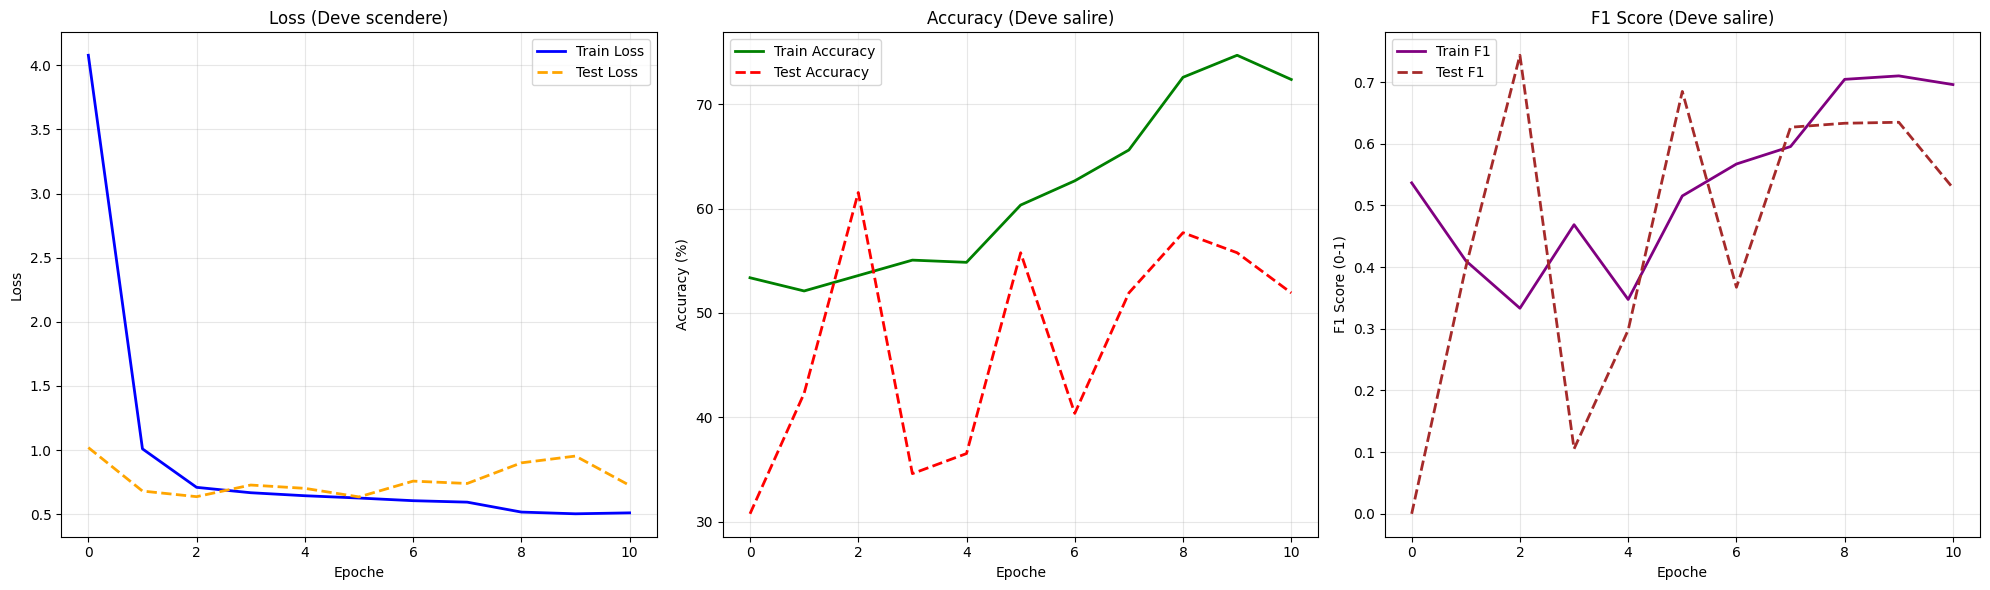

In [22]:
import matplotlib.pyplot as plt

# Creiamo una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# --- Grafico 1: LOSS (Errore) ---
# Questo ci dice se il modello sta imparando (deve scendere)
axs[0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
axs[0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
axs[0].set_title('Loss (Deve scendere)')
axs[0].set_xlabel('Epoche')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# --- Grafico 2: ACCURACY ---
# Ci dice la percentuale totale di risposte corrette (deve salire)
axs[1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
axs[1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Accuracy (Deve salire)')
axs[1].set_xlabel('Epoche')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# --- Grafico 3: F1 SCORE ---
# Critico per dati sbilanciati o medici: media armonica tra precisione e recupero
axs[2].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
axs[2].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
axs[2].set_title('F1 Score (Deve salire)')
axs[2].set_xlabel('Epoche')
axs[2].set_ylabel('F1 Score (0-1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout() # Aggiusta automaticamente gli spazi tra i grafici
plt.show()

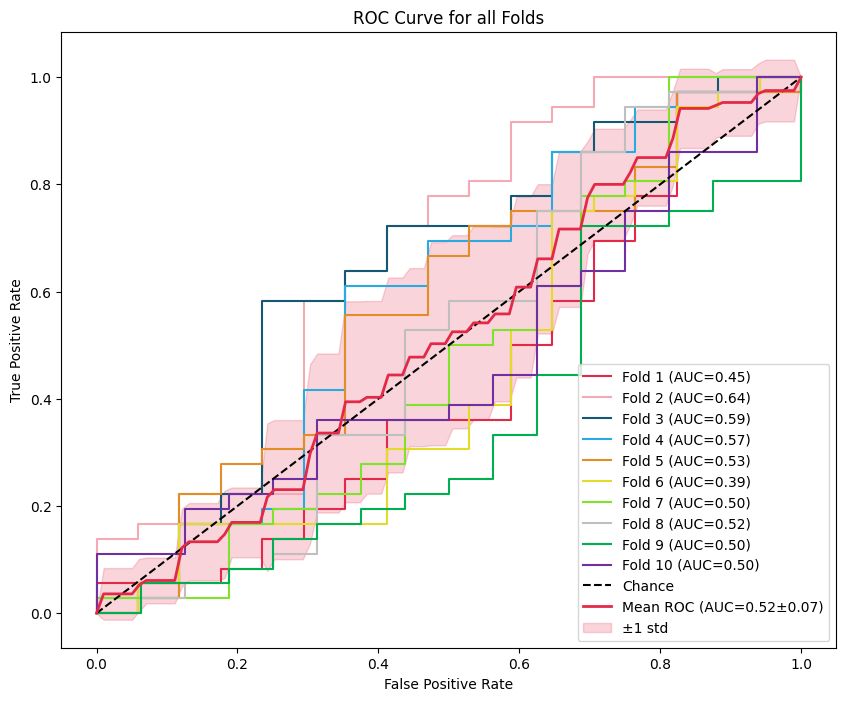

In [23]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

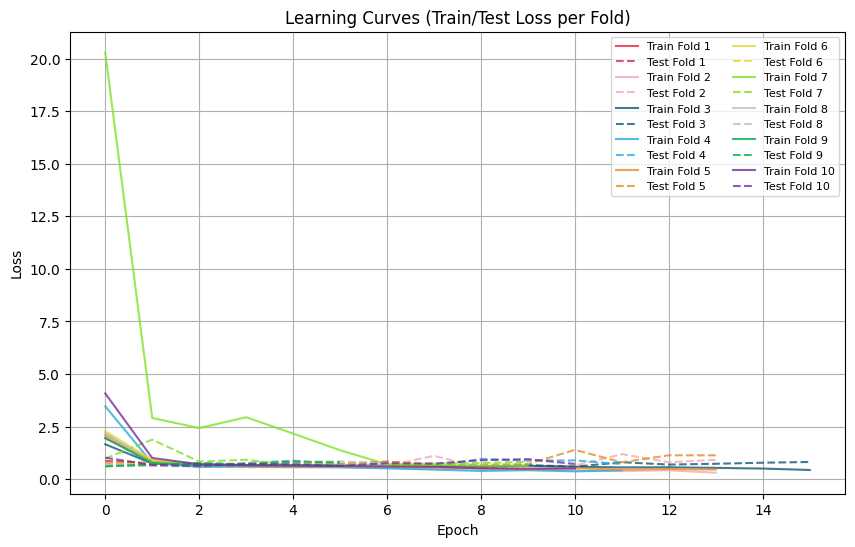

In [24]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===
      Accuracy  F1 Score  Sensitivity (Recall)  Specificity     AUC
mean    0.6105    0.7065                0.7611       0.2798  0.5204
std     0.1223    0.1651                0.2457       0.1986  0.0708
min     0.3208    0.2800                0.1944       0.0000  0.3913
max     0.7170    0.8235                1.0000       0.5882  0.6397


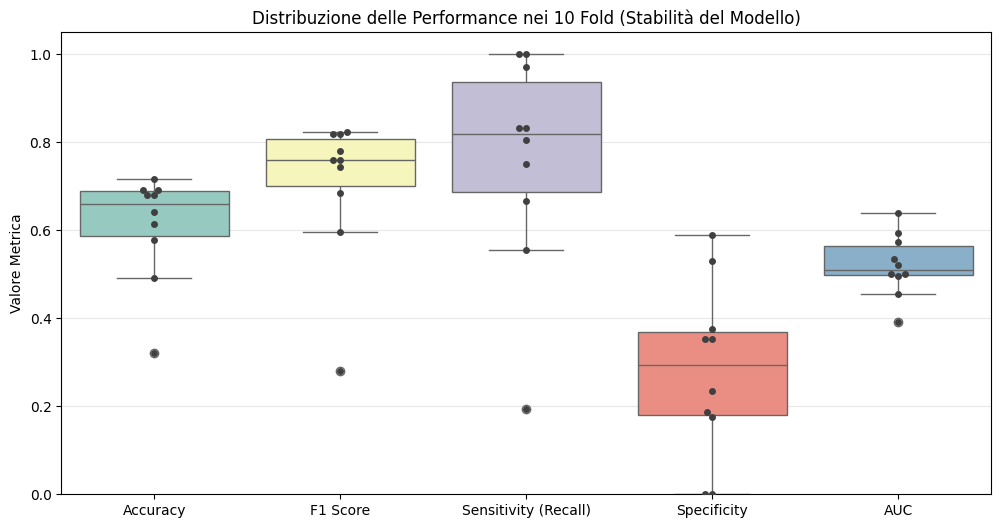

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Creazione di un DataFrame con tutti i risultati
results_data = {
    'Accuracy': np.array(accuracy_list_all_folds) / 100,  # <--- DIVISO PER 100
    'F1 Score': f1_list_all_folds,
    'Sensitivity (Recall)': sensitivity_list_all_folds,
    'Specificity': specificity_list_all_folds,
    'AUC': auc_score_list_all_folds
}

df_results = pd.DataFrame(results_data)

# 2. Calcolo delle Statistiche (Media e Deviazione Standard)
# La deviazione standard (std) ti dice quanto il modello è "instabile" tra un fold e l'altro
summary = df_results.describe().loc[['mean', 'std', 'min', 'max']]

print("=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===")
print(summary.round(4))

# 3. Visualizzazione Grafica (Boxplot)
# Questo grafico è fondamentale: la linea verde è la mediana, la scatola è dove cade il 50% dei casi.
# Se la scatola è molto "alta", il modello è instabile. Se è schiacciata, è molto robusto.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, palette="Set3")
sns.swarmplot(data=df_results, color=".25") # Aggiunge i punti reali per vedere la dispersione

plt.title('Distribuzione delle Performance nei 10 Fold (Stabilità del Modello)')
plt.ylabel('Valore Metrica')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.05) # Fissa l'asse Y tra 0 e 1 (o poco più per l'accuracy se è in %)
# Se l'accuracy è in scala 0-100, commenta la riga sopra o adattala a (0, 105)

plt.show();

# Modello 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoStreamCNN(nn.Module):
    def __init__(self):
        super(TwoStreamCNN, self).__init__()

        # --- RAMO 1: Derivazioni Periferiche (Limb Leads: I, II, III, aVR, aVL, aVF) ---
        # Input: 6 canali
        self.branch1 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # --- RAMO 2: Derivazioni Precordiali (Chest Leads: V1-V6) ---
        # Input: 6 canali
        self.branch2 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # --- BLOCCO DI FUSIONE ---
        # Concateniamo i risultati (64 canali + 64 canali = 128 canali)
        self.fusion_conv = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # Global Pooling per gestire qualsiasi lunghezza temporale
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classificatore Finale
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x shape: [Batch, 12, Length]

        # 1. Separiamo fisicamente i canali
        # I primi 6 canali vanno al Ramo 1
        input_limb = x[:, :6, :]
        # Gli ultimi 6 canali vanno al Ramo 2
        input_chest = x[:, 6:, :]

        # 2. Elaborazione Parallela
        out1 = self.branch1(input_limb)
        out2 = self.branch2(input_chest)

        # 3. Concatenazione lungo la dimensione dei canali (dim=1)
        # out1 e out2 devono avere la stessa lunghezza temporale (garantito dai MaxPool uguali)
        combined = torch.cat((out1, out2), dim=1)

        # 4. Fusione ed estrazione feature di alto livello
        features = self.fusion_conv(combined)

        # 5. Pooling e Classificazione
        features = self.global_pool(features).squeeze(-1)
        logits = self.classifier(features)

        return torch.sigmoid(logits)

In [ ]:
#implementation of the ten fold cross-validation

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    train_dataset = ECGDataset(ecg_train_segments, Y_train)
    test_dataset = ECGDataset(ecg_test_segments, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = TwoStreamCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ## Variabili early-stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for signals_ecg, labels in train_loader:
            model.train()
            # Rimosso tabular.to(device)
            signals_ecg, labels = signals_ecg.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passiamo solo il segnale al modello
            outputs = model(signals_ecg)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for signals_ecg, labels in test_loader:
                # Rimosso tabular.to(device)
                signals_ecg, labels = signals_ecg.to(device), labels.to(device)

                # Passiamo solo il segnale
                outputs = model(signals_ecg)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

            ## early stopping
            if test_loss < best_test_loss:
                 best_test_loss = test_loss
                 trigger_times = 0
                 # Salviamo i pesi del modello attuale perché è il migliore finora
                 torch.save(model.state_dict(), 'best_model_fold.pth')
            else:
                 trigger_times += 1
                 # print(f"Patience: {trigger_times}/{patience}") # Decommenta se vuoi vedere il contatore

                 if trigger_times >= patience:
                     print(f"Early stopping attivato all'epoca {epoch+1}!")
                     # IMPORTANTE: Prima di uscire, ricarichiamo i pesi migliori salvati
                     # Altrimenti il modello rimarrebbe quello "peggiorato" dell'ultima epoca
                     model.load_state_dict(torch.load('best_model_fold.pth'))
                     break # Esce dal ciclo "for epoch" e passa al prossimo Fold

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])



print(f"Accuracy: {accuracy_list_all_folds}")
print(f"Accuracy Train: {accuracy_list_all_folds_train}")
print(f"F1 Score: {f1_list_all_folds}")
print(f"F1 Score Train: {f1_list_all_folds_train}")
print(f"Sensitivity: {sensitivity_list_all_folds}")
print(f"Sensitivity Train: {sensitivity_list_all_folds_train}")
print(f"Specificity: {specificity_list_all_folds}")
print(f"Specificity Train: {specificity_list_all_folds_train}")
print(f"AUC: {auc_score_list_all_folds}")
print(f"AUC Train: {auc_score_list_all_folds_train}")
print(f"Test Loss: {test_loss_max}")
print(f"Train Loss: {train_loss_max}")
print(f"Epochs: {epochs_all_fold}")

  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1, Train Loss: 0.6379509846369426


  2%|▏         | 1/50 [00:01<01:19,  1.62s/it]

Test loss: 0.6296388506889343, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


Epoch 2, Train Loss: 0.6039203703403473


  4%|▍         | 2/50 [00:02<00:56,  1.18s/it]

Test loss: 0.5872561037540436, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


Epoch 3, Train Loss: 0.5705182313919067


  6%|▌         | 3/50 [00:03<00:50,  1.07s/it]

Test loss: 0.5653319954872131, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  8%|▊         | 4/50 [00:03<00:38,  1.20it/s]



Epoch 4, Train Loss: 0.5598134835561116
Test loss: 0.5643871128559113, Accuracy: 71.70% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 36, FP: 15, TN: 2, FN: 0


Epoch 5, Train Loss: 0.5563133458296458
Test loss: 0.541786327958107, Accuracy: 66.04% F1 Score: 0.7857, Sensitivity: 0.9167, Specificity: 0.1176, AUC: 0.5172
TP: 33, FP: 15, TN: 2, FN: 3


 12%|█▏        | 6/50 [00:04<00:26,  1.66it/s]



Epoch 6, Train Loss: 0.5212017953395843
Test loss: 0.56256103515625, Accuracy: 58.49% F1 Score: 0.7250, Sensitivity: 0.8056, Specificity: 0.1176, AUC: 0.4616
TP: 29, FP: 15, TN: 2, FN: 7


 14%|█▍        | 7/50 [00:05<00:22,  1.89it/s]



Epoch 7, Train Loss: 0.5121776501337687
Test loss: 0.5503851175308228, Accuracy: 64.15% F1 Score: 0.7654, Sensitivity: 0.8611, Specificity: 0.1765, AUC: 0.5188
TP: 31, FP: 14, TN: 3, FN: 5


 16%|█▌        | 8/50 [00:05<00:19,  2.10it/s]



Epoch 8, Train Loss: 0.48335351546605426
Test loss: 0.5598272383213043, Accuracy: 62.26% F1 Score: 0.7368, Sensitivity: 0.7778, Specificity: 0.2941, AUC: 0.5359
TP: 28, FP: 12, TN: 5, FN: 8


 18%|█▊        | 9/50 [00:05<00:18,  2.23it/s]



Epoch 9, Train Loss: 0.47941344380378725
Test loss: 0.5161876380443573, Accuracy: 73.58% F1 Score: 0.8000, Sensitivity: 0.7778, Specificity: 0.6471, AUC: 0.7124
TP: 28, FP: 6, TN: 11, FN: 8


 20%|██        | 10/50 [00:06<00:16,  2.38it/s]



Epoch 10, Train Loss: 0.4577972153822581
Test loss: 0.57931287586689, Accuracy: 62.26% F1 Score: 0.7500, Sensitivity: 0.8333, Specificity: 0.1765, AUC: 0.5049
TP: 30, FP: 14, TN: 3, FN: 6


 22%|██▏       | 11/50 [00:06<00:15,  2.48it/s]



Epoch 11, Train Loss: 0.47651870449384054
Test loss: 0.528932973742485, Accuracy: 66.04% F1 Score: 0.7750, Sensitivity: 0.8611, Specificity: 0.2353, AUC: 0.5482
TP: 31, FP: 13, TN: 4, FN: 5


 24%|██▍       | 12/50 [00:07<00:15,  2.49it/s]



Epoch 12, Train Loss: 0.47043225169181824
Test loss: 0.5845430493354797, Accuracy: 62.26% F1 Score: 0.7436, Sensitivity: 0.8056, Specificity: 0.2353, AUC: 0.5204
TP: 29, FP: 13, TN: 4, FN: 7


 26%|██▌       | 13/50 [00:07<00:14,  2.57it/s]



Epoch 13, Train Loss: 0.45790968736012777
Test loss: 0.5505212247371674, Accuracy: 62.26% F1 Score: 0.7561, Sensitivity: 0.8611, Specificity: 0.1176, AUC: 0.4894
TP: 31, FP: 15, TN: 2, FN: 5


Epoch 14, Train Loss: 0.433291753133138


 26%|██▌       | 13/50 [00:07<00:22,  1.64it/s]

Test loss: 0.5818399041891098, Accuracy: 64.15% F1 Score: 0.7654, Sensitivity: 0.8611, Specificity: 0.1765, AUC: 0.5188
TP: 31, FP: 14, TN: 3, FN: 5
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:18,  2.63it/s]



Epoch 1, Train Loss: 0.6249245882034302
Test loss: 0.629954606294632, Accuracy: 33.96% F1 Score: 0.0541, Sensitivity: 0.0278, Specificity: 1.0000, AUC: 0.5139
TP: 1, FP: 0, TN: 17, FN: 35


  4%|▍         | 2/50 [00:00<00:18,  2.56it/s]



Epoch 2, Train Loss: 0.5782694300015767
Test loss: 0.6069157421588898, Accuracy: 71.70% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2941, AUC: 0.6054
TP: 33, FP: 12, TN: 5, FN: 3


  6%|▌         | 3/50 [00:01<00:18,  2.49it/s]



Epoch 3, Train Loss: 0.5480061213175456
Test loss: 0.5737795531749725, Accuracy: 75.47% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4706, AUC: 0.6797
TP: 32, FP: 9, TN: 8, FN: 4


  8%|▊         | 4/50 [00:01<00:18,  2.53it/s]



Epoch 4, Train Loss: 0.5188766618569692
Test loss: 0.5886649489402771, Accuracy: 58.49% F1 Score: 0.6207, Sensitivity: 0.5000, Specificity: 0.7647, AUC: 0.6324
TP: 18, FP: 4, TN: 13, FN: 18


 10%|█         | 5/50 [00:02<00:18,  2.40it/s]



Epoch 5, Train Loss: 0.5284619410832723
Test loss: 0.5594597458839417, Accuracy: 69.81% F1 Score: 0.7576, Sensitivity: 0.6944, Specificity: 0.7059, AUC: 0.7002
TP: 25, FP: 5, TN: 12, FN: 11


 12%|█▏        | 6/50 [00:02<00:17,  2.48it/s]



Epoch 6, Train Loss: 0.4965198894341787
Test loss: 0.5600278675556183, Accuracy: 69.81% F1 Score: 0.7500, Sensitivity: 0.6667, Specificity: 0.7647, AUC: 0.7157
TP: 24, FP: 4, TN: 13, FN: 12


Epoch 7, Train Loss: 0.48545896212259926


 14%|█▍        | 7/50 [00:02<00:18,  2.32it/s]

Test loss: 0.5976295173168182, Accuracy: 71.70% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6471, AUC: 0.6985
TP: 27, FP: 6, TN: 11, FN: 9


 16%|█▌        | 8/50 [00:03<00:18,  2.23it/s]



Epoch 8, Train Loss: 0.49385663866996765
Test loss: 0.5373190194368362, Accuracy: 66.04% F1 Score: 0.7097, Sensitivity: 0.6111, Specificity: 0.7647, AUC: 0.6879
TP: 22, FP: 4, TN: 13, FN: 14


 18%|█▊        | 9/50 [00:03<00:17,  2.28it/s]



Epoch 9, Train Loss: 0.4663185278574626
Test loss: 0.5442908406257629, Accuracy: 67.92% F1 Score: 0.7213, Sensitivity: 0.6111, Specificity: 0.8235, AUC: 0.7173
TP: 22, FP: 3, TN: 14, FN: 14


Epoch 10, Train Loss: 0.4762179732322693
Test loss: 0.5617972761392593, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10


 20%|██        | 10/50 [00:04<00:17,  2.25it/s]



Epoch 11, Train Loss: 0.48505168755849204


 22%|██▏       | 11/50 [00:04<00:18,  2.16it/s]

Test loss: 0.5558214634656906, Accuracy: 69.81% F1 Score: 0.7714, Sensitivity: 0.7500, Specificity: 0.5882, AUC: 0.6691
TP: 27, FP: 7, TN: 10, FN: 9


Epoch 12, Train Loss: 0.4458778282006582


 24%|██▍       | 12/50 [00:05<00:19,  1.90it/s]

Test loss: 0.47418877482414246, Accuracy: 83.02% F1 Score: 0.8732, Sensitivity: 0.8611, Specificity: 0.7647, AUC: 0.8129
TP: 31, FP: 4, TN: 13, FN: 5


Epoch 13, Train Loss: 0.44877448280652366


 26%|██▌       | 13/50 [00:06<00:22,  1.65it/s]

Test loss: 0.5580855160951614, Accuracy: 73.58% F1 Score: 0.7879, Sensitivity: 0.7222, Specificity: 0.7647, AUC: 0.7435
TP: 26, FP: 4, TN: 13, FN: 10


Epoch 14, Train Loss: 0.421069081624349


 28%|██▊       | 14/50 [00:07<00:24,  1.48it/s]

Test loss: 0.5917313396930695, Accuracy: 67.92% F1 Score: 0.7385, Sensitivity: 0.6667, Specificity: 0.7059, AUC: 0.6863
TP: 24, FP: 5, TN: 12, FN: 12


Epoch 15, Train Loss: 0.44027841885884605


 30%|███       | 15/50 [00:07<00:22,  1.52it/s]

Test loss: 0.5905066579580307, Accuracy: 73.58% F1 Score: 0.7941, Sensitivity: 0.7500, Specificity: 0.7059, AUC: 0.7279
TP: 27, FP: 5, TN: 12, FN: 9


Epoch 16, Train Loss: 0.4657142639160156


 32%|███▏      | 16/50 [00:08<00:22,  1.54it/s]

Test loss: 0.5620761662721634, Accuracy: 71.70% F1 Score: 0.7619, Sensitivity: 0.6667, Specificity: 0.8235, AUC: 0.7451
TP: 24, FP: 3, TN: 14, FN: 12


 32%|███▏      | 16/50 [00:08<00:18,  1.81it/s]



Epoch 17, Train Loss: 0.4438444713751475
Test loss: 0.511457547545433, Accuracy: 66.04% F1 Score: 0.7000, Sensitivity: 0.5833, Specificity: 0.8235, AUC: 0.7034
TP: 21, FP: 3, TN: 14, FN: 15
Early stopping attivato all'epoca 17!



  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1, Train Loss: 0.6376477678616842


  2%|▏         | 1/50 [00:00<00:25,  1.90it/s]

Test loss: 0.6315317451953888, Accuracy: 73.58% F1 Score: 0.8372, Sensitivity: 1.0000, Specificity: 0.1765, AUC: 0.5882
TP: 36, FP: 14, TN: 3, FN: 0


  4%|▍         | 2/50 [00:00<00:23,  2.08it/s]



Epoch 2, Train Loss: 0.5955053528149923
Test loss: 0.597644567489624, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:21,  2.20it/s]



Epoch 3, Train Loss: 0.5631608545780182
Test loss: 0.594633936882019, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  8%|▊         | 4/50 [00:01<00:19,  2.33it/s]



Epoch 4, Train Loss: 0.5467879931131999
Test loss: 0.5815446078777313, Accuracy: 64.15% F1 Score: 0.7532, Sensitivity: 0.8056, Specificity: 0.2941, AUC: 0.5498
TP: 29, FP: 12, TN: 5, FN: 7


 10%|█         | 5/50 [00:02<00:18,  2.44it/s]



Epoch 5, Train Loss: 0.5447310109933218
Test loss: 0.5685014426708221, Accuracy: 58.49% F1 Score: 0.6562, Sensitivity: 0.5833, Specificity: 0.5882, AUC: 0.5858
TP: 21, FP: 7, TN: 10, FN: 15


 12%|█▏        | 6/50 [00:02<00:18,  2.40it/s]



Epoch 6, Train Loss: 0.5260083754857381
Test loss: 0.5814611613750458, Accuracy: 66.04% F1 Score: 0.7568, Sensitivity: 0.7778, Specificity: 0.4118, AUC: 0.5948
TP: 28, FP: 10, TN: 7, FN: 8


 14%|█▍        | 7/50 [00:02<00:17,  2.49it/s]



Epoch 7, Train Loss: 0.531881042321523
Test loss: 0.5878621190786362, Accuracy: 62.26% F1 Score: 0.6970, Sensitivity: 0.6389, Specificity: 0.5882, AUC: 0.6136
TP: 23, FP: 7, TN: 10, FN: 13


 16%|█▌        | 8/50 [00:03<00:17,  2.41it/s]



Epoch 8, Train Loss: 0.5097560306390126
Test loss: 0.5672906339168549, Accuracy: 66.04% F1 Score: 0.7429, Sensitivity: 0.7222, Specificity: 0.5294, AUC: 0.6258
TP: 26, FP: 8, TN: 9, FN: 10


 18%|█▊        | 9/50 [00:03<00:17,  2.41it/s]



Epoch 9, Train Loss: 0.5073471347490947
Test loss: 0.6054374277591705, Accuracy: 58.49% F1 Score: 0.6452, Sensitivity: 0.5556, Specificity: 0.6471, AUC: 0.6013
TP: 20, FP: 6, TN: 11, FN: 16


 20%|██        | 10/50 [00:04<00:15,  2.58it/s]



Epoch 10, Train Loss: 0.4914839148521423
Test loss: 0.5959220230579376, Accuracy: 66.04% F1 Score: 0.7188, Sensitivity: 0.6389, Specificity: 0.7059, AUC: 0.6724
TP: 23, FP: 5, TN: 12, FN: 13


 22%|██▏       | 11/50 [00:04<00:14,  2.76it/s]



Epoch 11, Train Loss: 0.4819569945335388
Test loss: 0.591281533241272, Accuracy: 67.92% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 27, FP: 8, TN: 9, FN: 9


 24%|██▍       | 12/50 [00:04<00:13,  2.87it/s]



Epoch 12, Train Loss: 0.4697638769944509
Test loss: 0.5576116591691971, Accuracy: 69.81% F1 Score: 0.7647, Sensitivity: 0.7222, Specificity: 0.6471, AUC: 0.6846
TP: 26, FP: 6, TN: 11, FN: 10


 26%|██▌       | 13/50 [00:05<00:12,  3.00it/s]



Epoch 13, Train Loss: 0.4586758335431417
Test loss: 0.6233262866735458, Accuracy: 54.72% F1 Score: 0.6000, Sensitivity: 0.5000, Specificity: 0.6471, AUC: 0.5735
TP: 18, FP: 6, TN: 11, FN: 18


 28%|██▊       | 14/50 [00:05<00:11,  3.06it/s]



Epoch 14, Train Loss: 0.47263588110605875
Test loss: 0.6549381762742996, Accuracy: 73.58% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3529, AUC: 0.6348
TP: 33, FP: 11, TN: 6, FN: 3


 30%|███       | 15/50 [00:05<00:11,  3.11it/s]



Epoch 15, Train Loss: 0.4456049621105194
Test loss: 0.5437385588884354, Accuracy: 67.92% F1 Score: 0.7463, Sensitivity: 0.6944, Specificity: 0.6471, AUC: 0.6708
TP: 25, FP: 6, TN: 11, FN: 11


 32%|███▏      | 16/50 [00:05<00:10,  3.18it/s]



Epoch 16, Train Loss: 0.44599366982777916
Test loss: 0.7049606144428253, Accuracy: 54.72% F1 Score: 0.5862, Sensitivity: 0.4722, Specificity: 0.7059, AUC: 0.5891
TP: 17, FP: 5, TN: 12, FN: 19


 34%|███▍      | 17/50 [00:06<00:10,  3.22it/s]



Epoch 17, Train Loss: 0.4557618776957194
Test loss: 0.5973235070705414, Accuracy: 60.38% F1 Score: 0.6667, Sensitivity: 0.5833, Specificity: 0.6471, AUC: 0.6152
TP: 21, FP: 6, TN: 11, FN: 15


 36%|███▌      | 18/50 [00:06<00:09,  3.25it/s]



Epoch 18, Train Loss: 0.45869221885999045
Test loss: 0.5515476167201996, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11


 38%|███▊      | 19/50 [00:06<00:09,  3.29it/s]



Epoch 19, Train Loss: 0.4438178340593974
Test loss: 0.7074671536684036, Accuracy: 71.70% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2941, AUC: 0.6054
TP: 33, FP: 12, TN: 5, FN: 3


 38%|███▊      | 19/50 [00:07<00:11,  2.64it/s]



Epoch 20, Train Loss: 0.45302852789560955
Test loss: 0.6112425029277802, Accuracy: 67.92% F1 Score: 0.7792, Sensitivity: 0.8333, Specificity: 0.3529, AUC: 0.5931
TP: 30, FP: 11, TN: 6, FN: 6
Early stopping attivato all'epoca 20!



  2%|▏         | 1/50 [00:00<00:15,  3.23it/s]



Epoch 1, Train Loss: 0.6368269562721253
Test loss: 0.630869597196579, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  4%|▍         | 2/50 [00:00<00:14,  3.23it/s]



Epoch 2, Train Loss: 0.5951915423075358
Test loss: 0.6062462031841278, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.16it/s]



Epoch 3, Train Loss: 0.5772081236044566
Test loss: 0.5894338190555573, Accuracy: 66.04% F1 Score: 0.7907, Sensitivity: 0.9444, Specificity: 0.0588, AUC: 0.5016
TP: 34, FP: 16, TN: 1, FN: 2


  8%|▊         | 4/50 [00:01<00:14,  3.18it/s]



Epoch 4, Train Loss: 0.5560289939244588
Test loss: 0.5817089378833771, Accuracy: 69.81% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2941, AUC: 0.5915
TP: 32, FP: 12, TN: 5, FN: 4


 10%|█         | 5/50 [00:01<00:14,  3.21it/s]



Epoch 5, Train Loss: 0.544310329357783
Test loss: 0.5843515992164612, Accuracy: 69.81% F1 Score: 0.7714, Sensitivity: 0.7500, Specificity: 0.5882, AUC: 0.6691
TP: 27, FP: 7, TN: 10, FN: 9


 12%|█▏        | 6/50 [00:01<00:15,  2.93it/s]



Epoch 6, Train Loss: 0.5236334105332693
Test loss: 0.5750995576381683, Accuracy: 67.92% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5882, AUC: 0.6552
TP: 26, FP: 7, TN: 10, FN: 10


 14%|█▍        | 7/50 [00:02<00:15,  2.86it/s]



Epoch 7, Train Loss: 0.5196106453736623
Test loss: 0.5747285485267639, Accuracy: 73.58% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5294, AUC: 0.6814
TP: 30, FP: 8, TN: 9, FN: 6


 16%|█▌        | 8/50 [00:02<00:14,  2.84it/s]



Epoch 8, Train Loss: 0.48619508544603984
Test loss: 0.722797304391861, Accuracy: 62.26% F1 Score: 0.6552, Sensitivity: 0.5278, Specificity: 0.8235, AUC: 0.6757
TP: 19, FP: 3, TN: 14, FN: 17


 18%|█▊        | 9/50 [00:03<00:14,  2.77it/s]



Epoch 9, Train Loss: 0.4911258280277252
Test loss: 0.6299378275871277, Accuracy: 75.47% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.4118, AUC: 0.6642
TP: 33, FP: 10, TN: 7, FN: 3


 20%|██        | 10/50 [00:03<00:14,  2.78it/s]



Epoch 10, Train Loss: 0.4810405651728312
Test loss: 0.7213524132966995, Accuracy: 62.26% F1 Score: 0.6667, Sensitivity: 0.5556, Specificity: 0.7647, AUC: 0.6601
TP: 20, FP: 4, TN: 13, FN: 16


 22%|██▏       | 11/50 [00:03<00:14,  2.78it/s]



Epoch 11, Train Loss: 0.48373008569081627
Test loss: 0.6728247255086899, Accuracy: 71.70% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1765, AUC: 0.5743
TP: 35, FP: 14, TN: 3, FN: 1


 22%|██▏       | 11/50 [00:04<00:14,  2.63it/s]



Epoch 12, Train Loss: 0.49155380924542746
Test loss: 0.6360985636711121, Accuracy: 66.04% F1 Score: 0.7000, Sensitivity: 0.5833, Specificity: 0.8235, AUC: 0.7034
TP: 21, FP: 3, TN: 14, FN: 15
Early stopping attivato all'epoca 12!



  2%|▏         | 1/50 [00:00<00:15,  3.19it/s]



Epoch 1, Train Loss: 0.641744871934255
Test loss: 0.6239536702632904, Accuracy: 71.70% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 36, FP: 15, TN: 2, FN: 0


  4%|▍         | 2/50 [00:00<00:20,  2.39it/s]



Epoch 2, Train Loss: 0.6060032447179159
Test loss: 0.5870837420225143, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:17,  2.71it/s]



Epoch 3, Train Loss: 0.5850316445032756
Test loss: 0.5516407191753387, Accuracy: 71.70% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1765, AUC: 0.5743
TP: 35, FP: 14, TN: 3, FN: 1


  8%|▊         | 4/50 [00:01<00:16,  2.87it/s]



Epoch 4, Train Loss: 0.5542681972185771
Test loss: 0.5162772834300995, Accuracy: 75.47% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3529, AUC: 0.6487
TP: 34, FP: 11, TN: 6, FN: 2


 10%|█         | 5/50 [00:01<00:15,  2.98it/s]



Epoch 5, Train Loss: 0.5367322246233622
Test loss: 0.510542631149292, Accuracy: 75.47% F1 Score: 0.8434, Sensitivity: 0.9722, Specificity: 0.2941, AUC: 0.6332
TP: 35, FP: 12, TN: 5, FN: 1


 12%|█▏        | 6/50 [00:02<00:14,  3.10it/s]



Epoch 6, Train Loss: 0.5205688854058583
Test loss: 0.7432312965393066, Accuracy: 52.83% F1 Score: 0.5283, Sensitivity: 0.3889, Specificity: 0.8235, AUC: 0.6062
TP: 14, FP: 3, TN: 14, FN: 22


 14%|█▍        | 7/50 [00:02<00:13,  3.08it/s]



Epoch 7, Train Loss: 0.5159185489018758
Test loss: 0.5066417753696442, Accuracy: 71.70% F1 Score: 0.8193, Sensitivity: 0.9444, Specificity: 0.2353, AUC: 0.5899
TP: 34, FP: 13, TN: 4, FN: 2


 16%|█▌        | 8/50 [00:02<00:13,  3.14it/s]



Epoch 8, Train Loss: 0.49211324254671734
Test loss: 0.5073768198490143, Accuracy: 75.47% F1 Score: 0.8267, Sensitivity: 0.8611, Specificity: 0.5294, AUC: 0.6953
TP: 31, FP: 8, TN: 9, FN: 5


 18%|█▊        | 9/50 [00:02<00:12,  3.22it/s]



Epoch 9, Train Loss: 0.49622584382692975
Test loss: 0.538051649928093, Accuracy: 71.70% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5882, AUC: 0.6830
TP: 28, FP: 7, TN: 10, FN: 8


 20%|██        | 10/50 [00:03<00:12,  3.26it/s]



Epoch 10, Train Loss: 0.4699883004029592
Test loss: 0.6062533557415009, Accuracy: 64.15% F1 Score: 0.7077, Sensitivity: 0.6389, Specificity: 0.6471, AUC: 0.6430
TP: 23, FP: 6, TN: 11, FN: 13


 22%|██▏       | 11/50 [00:03<00:12,  3.25it/s]



Epoch 11, Train Loss: 0.47271688580513
Test loss: 0.5380616337060928, Accuracy: 71.70% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5882, AUC: 0.6830
TP: 28, FP: 7, TN: 10, FN: 8


 22%|██▏       | 11/50 [00:03<00:13,  2.83it/s]



Epoch 12, Train Loss: 0.4599468429883321
Test loss: 0.5183060169219971, Accuracy: 75.47% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.4118, AUC: 0.6642
TP: 33, FP: 10, TN: 7, FN: 3
Early stopping attivato all'epoca 12!



  2%|▏         | 1/50 [00:00<00:15,  3.07it/s]



Epoch 1, Train Loss: 0.6304110685984293
Test loss: 0.6200008690357208, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.15it/s]



Epoch 2, Train Loss: 0.5961848060290019
Test loss: 0.589732438325882, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  6%|▌         | 3/50 [00:00<00:14,  3.16it/s]



Epoch 3, Train Loss: 0.5615386704603831
Test loss: 0.5485723465681076, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.16it/s]



Epoch 4, Train Loss: 0.5488346636295318
Test loss: 0.5190532952547073, Accuracy: 69.81% F1 Score: 0.7895, Sensitivity: 0.8333, Specificity: 0.4118, AUC: 0.6225
TP: 30, FP: 10, TN: 7, FN: 6


 10%|█         | 5/50 [00:01<00:14,  3.19it/s]



Epoch 5, Train Loss: 0.5239727318286895
Test loss: 0.5330962538719177, Accuracy: 67.92% F1 Score: 0.7848, Sensitivity: 0.8611, Specificity: 0.2941, AUC: 0.5776
TP: 31, FP: 12, TN: 5, FN: 5


 12%|█▏        | 6/50 [00:01<00:13,  3.23it/s]



Epoch 6, Train Loss: 0.5131036480267842
Test loss: 0.5400497168302536, Accuracy: 64.15% F1 Score: 0.7532, Sensitivity: 0.8056, Specificity: 0.2941, AUC: 0.5498
TP: 29, FP: 12, TN: 5, FN: 7


 14%|█▍        | 7/50 [00:02<00:13,  3.26it/s]



Epoch 7, Train Loss: 0.5042862872282664
Test loss: 0.5231492221355438, Accuracy: 71.70% F1 Score: 0.7945, Sensitivity: 0.8056, Specificity: 0.5294, AUC: 0.6675
TP: 29, FP: 8, TN: 9, FN: 7


 16%|█▌        | 8/50 [00:02<00:12,  3.23it/s]



Epoch 8, Train Loss: 0.5042016486326854
Test loss: 0.505608856678009, Accuracy: 69.81% F1 Score: 0.7576, Sensitivity: 0.6944, Specificity: 0.7059, AUC: 0.7002
TP: 25, FP: 5, TN: 12, FN: 11


 18%|█▊        | 9/50 [00:02<00:12,  3.25it/s]



Epoch 9, Train Loss: 0.511415978272756
Test loss: 0.5583150237798691, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


 20%|██        | 10/50 [00:03<00:12,  3.23it/s]



Epoch 10, Train Loss: 0.5053745110829672
Test loss: 0.4876401126384735, Accuracy: 69.81% F1 Score: 0.7576, Sensitivity: 0.6944, Specificity: 0.7059, AUC: 0.7002
TP: 25, FP: 5, TN: 12, FN: 11


 22%|██▏       | 11/50 [00:03<00:12,  3.21it/s]



Epoch 11, Train Loss: 0.4784832159678141
Test loss: 0.539589449763298, Accuracy: 69.81% F1 Score: 0.7895, Sensitivity: 0.8333, Specificity: 0.4118, AUC: 0.6225
TP: 30, FP: 10, TN: 7, FN: 6


 24%|██▍       | 12/50 [00:03<00:11,  3.25it/s]



Epoch 12, Train Loss: 0.4591043074925741
Test loss: 0.5354543775320053, Accuracy: 64.15% F1 Score: 0.7077, Sensitivity: 0.6389, Specificity: 0.6471, AUC: 0.6430
TP: 23, FP: 6, TN: 11, FN: 13


 26%|██▌       | 13/50 [00:04<00:11,  3.27it/s]



Epoch 13, Train Loss: 0.46007014711697897
Test loss: 0.4961525797843933, Accuracy: 71.70% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6471, AUC: 0.6985
TP: 27, FP: 6, TN: 11, FN: 9


 28%|██▊       | 14/50 [00:04<00:11,  3.24it/s]



Epoch 14, Train Loss: 0.47456074754397076
Test loss: 0.5971223413944244, Accuracy: 66.04% F1 Score: 0.7000, Sensitivity: 0.5833, Specificity: 0.8235, AUC: 0.7034
TP: 21, FP: 3, TN: 14, FN: 15


 28%|██▊       | 14/50 [00:04<00:11,  3.00it/s]



Epoch 15, Train Loss: 0.46467400789260865
Test loss: 0.6793024241924286, Accuracy: 67.92% F1 Score: 0.8000, Sensitivity: 0.9444, Specificity: 0.1176, AUC: 0.5310
TP: 34, FP: 15, TN: 2, FN: 2
Early stopping attivato all'epoca 15!



  2%|▏         | 1/50 [00:00<00:24,  2.02it/s]



Epoch 1, Train Loss: 0.6491867025693258
Test loss: 0.6301519274711609, Accuracy: 46.15% F1 Score: 0.5625, Sensitivity: 0.5000, Specificity: 0.3750, AUC: 0.4375
TP: 18, FP: 10, TN: 6, FN: 18


  4%|▍         | 2/50 [00:00<00:20,  2.39it/s]



Epoch 2, Train Loss: 0.5992087880770366
Test loss: 0.6003628969192505, Accuracy: 75.00% F1 Score: 0.8471, Sensitivity: 1.0000, Specificity: 0.1875, AUC: 0.5938
TP: 36, FP: 13, TN: 3, FN: 0


  6%|▌         | 3/50 [00:01<00:18,  2.53it/s]



Epoch 3, Train Loss: 0.5918140451113383
Test loss: 0.564887672662735, Accuracy: 73.08% F1 Score: 0.8333, Sensitivity: 0.9722, Specificity: 0.1875, AUC: 0.5799
TP: 35, FP: 13, TN: 3, FN: 1


  8%|▊         | 4/50 [00:01<00:17,  2.58it/s]



Epoch 4, Train Loss: 0.5675671696662903
Test loss: 0.5318832397460938, Accuracy: 71.15% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6250, AUC: 0.6875
TP: 27, FP: 6, TN: 10, FN: 9


 10%|█         | 5/50 [00:01<00:17,  2.64it/s]



Epoch 5, Train Loss: 0.543141770362854
Test loss: 0.5193352103233337, Accuracy: 67.31% F1 Score: 0.7792, Sensitivity: 0.8333, Specificity: 0.3125, AUC: 0.5729
TP: 30, FP: 11, TN: 5, FN: 6


 12%|█▏        | 6/50 [00:02<00:16,  2.66it/s]



Epoch 6, Train Loss: 0.5369709153970083
Test loss: 0.49345560371875763, Accuracy: 75.00% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4375, AUC: 0.6632
TP: 32, FP: 9, TN: 7, FN: 4


 14%|█▍        | 7/50 [00:02<00:15,  2.72it/s]



Epoch 7, Train Loss: 0.5295842170715332
Test loss: 0.497368186712265, Accuracy: 67.31% F1 Score: 0.7792, Sensitivity: 0.8333, Specificity: 0.3125, AUC: 0.5729
TP: 30, FP: 11, TN: 5, FN: 6


 16%|█▌        | 8/50 [00:03<00:15,  2.75it/s]



Epoch 8, Train Loss: 0.5276636222998301
Test loss: 0.534471720457077, Accuracy: 75.00% F1 Score: 0.8434, Sensitivity: 0.9722, Specificity: 0.2500, AUC: 0.6111
TP: 35, FP: 12, TN: 4, FN: 1


 18%|█▊        | 9/50 [00:03<00:15,  2.71it/s]



Epoch 9, Train Loss: 0.5098395764827728
Test loss: 0.4854120463132858, Accuracy: 80.77% F1 Score: 0.8684, Sensitivity: 0.9167, Specificity: 0.5625, AUC: 0.7396
TP: 33, FP: 7, TN: 9, FN: 3


 20%|██        | 10/50 [00:03<00:14,  2.74it/s]



Epoch 10, Train Loss: 0.48828716079394024
Test loss: 0.4875762611627579, Accuracy: 67.31% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7500, AUC: 0.6944
TP: 23, FP: 4, TN: 12, FN: 13


 22%|██▏       | 11/50 [00:04<00:13,  2.89it/s]



Epoch 11, Train Loss: 0.48250194390614826
Test loss: 0.5084114521741867, Accuracy: 76.92% F1 Score: 0.8500, Sensitivity: 0.9444, Specificity: 0.3750, AUC: 0.6597
TP: 34, FP: 10, TN: 6, FN: 2


 24%|██▍       | 12/50 [00:04<00:12,  2.95it/s]



Epoch 12, Train Loss: 0.44681225419044496
Test loss: 0.4761612117290497, Accuracy: 80.77% F1 Score: 0.8684, Sensitivity: 0.9167, Specificity: 0.5625, AUC: 0.7396
TP: 33, FP: 7, TN: 9, FN: 3


 26%|██▌       | 13/50 [00:04<00:12,  3.03it/s]



Epoch 13, Train Loss: 0.4641454716523488
Test loss: 0.5203651040792465, Accuracy: 76.92% F1 Score: 0.8421, Sensitivity: 0.8889, Specificity: 0.5000, AUC: 0.6944
TP: 32, FP: 8, TN: 8, FN: 4


 28%|██▊       | 14/50 [00:05<00:11,  3.11it/s]



Epoch 14, Train Loss: 0.48038059870402017
Test loss: 0.4889051914215088, Accuracy: 78.85% F1 Score: 0.8608, Sensitivity: 0.9444, Specificity: 0.4375, AUC: 0.6910
TP: 34, FP: 9, TN: 7, FN: 2


 30%|███       | 15/50 [00:05<00:11,  3.14it/s]



Epoch 15, Train Loss: 0.45273423989613854
Test loss: 0.4583275765180588, Accuracy: 71.15% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5625, AUC: 0.6701
TP: 28, FP: 7, TN: 9, FN: 8


 32%|███▏      | 16/50 [00:05<00:10,  3.19it/s]



Epoch 16, Train Loss: 0.44016244014104206
Test loss: 0.5458751618862152, Accuracy: 78.85% F1 Score: 0.8608, Sensitivity: 0.9444, Specificity: 0.4375, AUC: 0.6910
TP: 34, FP: 9, TN: 7, FN: 2


 34%|███▍      | 17/50 [00:05<00:10,  3.22it/s]



Epoch 17, Train Loss: 0.44989158312479655
Test loss: 0.4660302698612213, Accuracy: 73.08% F1 Score: 0.8000, Sensitivity: 0.7778, Specificity: 0.6250, AUC: 0.7014
TP: 28, FP: 6, TN: 10, FN: 8


 36%|███▌      | 18/50 [00:06<00:09,  3.25it/s]



Epoch 18, Train Loss: 0.4697041094303131
Test loss: 0.5063009709119797, Accuracy: 75.00% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4375, AUC: 0.6632
TP: 32, FP: 9, TN: 7, FN: 4


 38%|███▊      | 19/50 [00:06<00:09,  3.28it/s]



Epoch 19, Train Loss: 0.43232065240542095
Test loss: 0.5146832913160324, Accuracy: 78.85% F1 Score: 0.8642, Sensitivity: 0.9722, Specificity: 0.3750, AUC: 0.6736
TP: 35, FP: 10, TN: 6, FN: 1


 38%|███▊      | 19/50 [00:06<00:11,  2.77it/s]



Epoch 20, Train Loss: 0.4208796282609304
Test loss: 0.5804974287748337, Accuracy: 78.85% F1 Score: 0.8642, Sensitivity: 0.9722, Specificity: 0.3750, AUC: 0.6736
TP: 35, FP: 10, TN: 6, FN: 1
Early stopping attivato all'epoca 20!



  2%|▏         | 1/50 [00:00<00:15,  3.19it/s]



Epoch 1, Train Loss: 0.6382309953371684
Test loss: 0.6184355616569519, Accuracy: 67.31% F1 Score: 0.7952, Sensitivity: 0.9167, Specificity: 0.1250, AUC: 0.5208
TP: 33, FP: 14, TN: 2, FN: 3


  4%|▍         | 2/50 [00:00<00:15,  3.16it/s]



Epoch 2, Train Loss: 0.6005425890286763
Test loss: 0.5748702734708786, Accuracy: 71.15% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.0625, AUC: 0.5312
TP: 36, FP: 15, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.16it/s]



Epoch 3, Train Loss: 0.5770950198173523
Test loss: 0.5513990670442581, Accuracy: 69.23% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2500, AUC: 0.5694
TP: 32, FP: 12, TN: 4, FN: 4


  8%|▊         | 4/50 [00:01<00:14,  3.17it/s]



Epoch 4, Train Loss: 0.552246767282486
Test loss: 0.5200769752264023, Accuracy: 67.31% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7500, AUC: 0.6944
TP: 23, FP: 4, TN: 12, FN: 13


 10%|█         | 5/50 [00:01<00:14,  3.16it/s]



Epoch 5, Train Loss: 0.5583774089813233
Test loss: 0.501742959022522, Accuracy: 69.23% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2500, AUC: 0.5694
TP: 32, FP: 12, TN: 4, FN: 4


 12%|█▏        | 6/50 [00:01<00:13,  3.21it/s]



Epoch 6, Train Loss: 0.532255748907725
Test loss: 0.5216837376356125, Accuracy: 67.31% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7500, AUC: 0.6944
TP: 23, FP: 4, TN: 12, FN: 13


 14%|█▍        | 7/50 [00:02<00:13,  3.23it/s]



Epoch 7, Train Loss: 0.5154862105846405
Test loss: 0.5644545406103134, Accuracy: 65.38% F1 Score: 0.7273, Sensitivity: 0.6667, Specificity: 0.6250, AUC: 0.6458
TP: 24, FP: 6, TN: 10, FN: 12


 16%|█▌        | 8/50 [00:02<00:12,  3.26it/s]



Epoch 8, Train Loss: 0.525126188993454
Test loss: 0.5576649457216263, Accuracy: 73.08% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2500, AUC: 0.5972
TP: 34, FP: 12, TN: 4, FN: 2


 18%|█▊        | 9/50 [00:02<00:12,  3.27it/s]



Epoch 9, Train Loss: 0.5265883406003317
Test loss: 0.5183284133672714, Accuracy: 69.23% F1 Score: 0.7714, Sensitivity: 0.7500, Specificity: 0.5625, AUC: 0.6562
TP: 27, FP: 7, TN: 9, FN: 9


 20%|██        | 10/50 [00:03<00:12,  3.24it/s]



Epoch 10, Train Loss: 0.5219774822394053
Test loss: 0.4689137637615204, Accuracy: 67.31% F1 Score: 0.7671, Sensitivity: 0.7778, Specificity: 0.4375, AUC: 0.6076
TP: 28, FP: 9, TN: 7, FN: 8


 22%|██▏       | 11/50 [00:03<00:12,  3.21it/s]



Epoch 11, Train Loss: 0.513547545671463
Test loss: 0.46651165187358856, Accuracy: 71.15% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.6875, AUC: 0.7049
TP: 26, FP: 5, TN: 11, FN: 10


 24%|██▍       | 12/50 [00:03<00:11,  3.22it/s]



Epoch 12, Train Loss: 0.5058707793553671
Test loss: 0.5226915329694748, Accuracy: 67.31% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5625, AUC: 0.6424
TP: 26, FP: 7, TN: 9, FN: 10


 26%|██▌       | 13/50 [00:04<00:11,  3.24it/s]



Epoch 13, Train Loss: 0.5044338683287303
Test loss: 0.48725126683712006, Accuracy: 76.92% F1 Score: 0.8235, Sensitivity: 0.7778, Specificity: 0.7500, AUC: 0.7639
TP: 28, FP: 4, TN: 12, FN: 8


 28%|██▊       | 14/50 [00:04<00:11,  3.23it/s]



Epoch 14, Train Loss: 0.4907622178395589
Test loss: 0.46185773611068726, Accuracy: 71.15% F1 Score: 0.8000, Sensitivity: 0.8333, Specificity: 0.4375, AUC: 0.6354
TP: 30, FP: 9, TN: 7, FN: 6


 30%|███       | 15/50 [00:04<00:10,  3.22it/s]



Epoch 15, Train Loss: 0.476762455701828
Test loss: 0.5230150371789932, Accuracy: 73.08% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5625, AUC: 0.6840
TP: 29, FP: 7, TN: 9, FN: 7


 32%|███▏      | 16/50 [00:04<00:10,  3.25it/s]



Epoch 16, Train Loss: 0.48405036330223083
Test loss: 0.5101245492696762, Accuracy: 76.92% F1 Score: 0.8378, Sensitivity: 0.8611, Specificity: 0.5625, AUC: 0.7118
TP: 31, FP: 7, TN: 9, FN: 5


 34%|███▍      | 17/50 [00:05<00:10,  3.26it/s]



Epoch 17, Train Loss: 0.4694671134154002
Test loss: 0.49611320346593857, Accuracy: 71.15% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3125, AUC: 0.6007
TP: 32, FP: 11, TN: 5, FN: 4


 36%|███▌      | 18/50 [00:05<00:09,  3.21it/s]



Epoch 18, Train Loss: 0.4630642354488373
Test loss: 0.42900450527668, Accuracy: 76.92% F1 Score: 0.8286, Sensitivity: 0.8056, Specificity: 0.6875, AUC: 0.7465
TP: 29, FP: 5, TN: 11, FN: 7


 38%|███▊      | 19/50 [00:05<00:09,  3.21it/s]



Epoch 19, Train Loss: 0.4588049550851186
Test loss: 0.48729728162288666, Accuracy: 73.08% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5000, AUC: 0.6667
TP: 30, FP: 8, TN: 8, FN: 6


 40%|████      | 20/50 [00:06<00:09,  3.24it/s]



Epoch 20, Train Loss: 0.4472557584444682
Test loss: 0.48087556660175323, Accuracy: 71.15% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5625, AUC: 0.6701
TP: 28, FP: 7, TN: 9, FN: 8


 42%|████▏     | 21/50 [00:06<00:08,  3.24it/s]



Epoch 21, Train Loss: 0.44781378308931985
Test loss: 0.48003796488046646, Accuracy: 75.00% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3125, AUC: 0.6285
TP: 34, FP: 11, TN: 5, FN: 2


 44%|████▍     | 22/50 [00:06<00:09,  3.08it/s]



Epoch 22, Train Loss: 0.43651792804400125
Test loss: 0.5511480271816254, Accuracy: 71.15% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.6875, AUC: 0.7049
TP: 26, FP: 5, TN: 11, FN: 10


 44%|████▍     | 22/50 [00:07<00:09,  3.04it/s]



Epoch 23, Train Loss: 0.42863176663716634
Test loss: 0.5277489870786667, Accuracy: 67.31% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5000, AUC: 0.6250
TP: 27, FP: 8, TN: 8, FN: 9
Early stopping attivato all'epoca 23!



  2%|▏         | 1/50 [00:00<00:18,  2.69it/s]



Epoch 1, Train Loss: 0.6248463789621989
Test loss: 0.6096855103969574, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:17,  2.73it/s]



Epoch 2, Train Loss: 0.5898777365684509
Test loss: 0.6079405546188354, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:17,  2.69it/s]



Epoch 3, Train Loss: 0.5570825974146525
Test loss: 0.6544395387172699, Accuracy: 63.46% F1 Score: 0.7654, Sensitivity: 0.8611, Specificity: 0.1250, AUC: 0.4931
TP: 31, FP: 14, TN: 2, FN: 5


  8%|▊         | 4/50 [00:01<00:17,  2.65it/s]



Epoch 4, Train Loss: 0.5263057887554169
Test loss: 0.671612948179245, Accuracy: 55.77% F1 Score: 0.6761, Sensitivity: 0.6667, Specificity: 0.3125, AUC: 0.4896
TP: 24, FP: 11, TN: 5, FN: 12


 10%|█         | 5/50 [00:01<00:16,  2.71it/s]



Epoch 5, Train Loss: 0.51462655266126
Test loss: 0.7596676349639893, Accuracy: 53.85% F1 Score: 0.6129, Sensitivity: 0.5278, Specificity: 0.5625, AUC: 0.5451
TP: 19, FP: 7, TN: 9, FN: 17


 12%|█▏        | 6/50 [00:02<00:15,  2.86it/s]



Epoch 6, Train Loss: 0.509495735168457
Test loss: 0.751541256904602, Accuracy: 55.77% F1 Score: 0.6761, Sensitivity: 0.6667, Specificity: 0.3125, AUC: 0.4896
TP: 24, FP: 11, TN: 5, FN: 12


 12%|█▏        | 6/50 [00:02<00:18,  2.42it/s]



Epoch 7, Train Loss: 0.5121707061926524
Test loss: 0.7375665605068207, Accuracy: 46.15% F1 Score: 0.5625, Sensitivity: 0.5000, Specificity: 0.3750, AUC: 0.4375
TP: 18, FP: 10, TN: 6, FN: 18
Early stopping attivato all'epoca 7!



  2%|▏         | 1/50 [00:00<00:15,  3.15it/s]



Epoch 1, Train Loss: 0.6409847338994344
Test loss: 0.6287938356399536, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.11it/s]



Epoch 2, Train Loss: 0.5995868563652038
Test loss: 0.6118138134479523, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:15,  3.13it/s]



Epoch 3, Train Loss: 0.5772165278593699
Test loss: 0.5955603122711182, Accuracy: 71.15% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.0625, AUC: 0.5312
TP: 36, FP: 15, TN: 1, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.13it/s]



Epoch 4, Train Loss: 0.556286899248759
Test loss: 0.6156730949878693, Accuracy: 69.23% F1 Score: 0.8095, Sensitivity: 0.9444, Specificity: 0.1250, AUC: 0.5347
TP: 34, FP: 14, TN: 2, FN: 2


 10%|█         | 5/50 [00:01<00:14,  3.16it/s]



Epoch 5, Train Loss: 0.5181136846542358
Test loss: 0.5553770363330841, Accuracy: 75.00% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3125, AUC: 0.6285
TP: 34, FP: 11, TN: 5, FN: 2


 12%|█▏        | 6/50 [00:01<00:13,  3.21it/s]



Epoch 6, Train Loss: 0.5084311505158742
Test loss: 0.5567731112241745, Accuracy: 78.85% F1 Score: 0.8533, Sensitivity: 0.8889, Specificity: 0.5625, AUC: 0.7257
TP: 32, FP: 7, TN: 9, FN: 4


 14%|█▍        | 7/50 [00:02<00:13,  3.25it/s]



Epoch 7, Train Loss: 0.5032921115557353
Test loss: 0.5771938860416412, Accuracy: 63.46% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.6875, AUC: 0.6493
TP: 22, FP: 5, TN: 11, FN: 14


 16%|█▌        | 8/50 [00:02<00:12,  3.25it/s]



Epoch 8, Train Loss: 0.48818182945251465
Test loss: 0.6214805841445923, Accuracy: 67.31% F1 Score: 0.7733, Sensitivity: 0.8056, Specificity: 0.3750, AUC: 0.5903
TP: 29, FP: 10, TN: 6, FN: 7


 18%|█▊        | 9/50 [00:02<00:12,  3.27it/s]



Epoch 9, Train Loss: 0.48213433027267455
Test loss: 0.5981269180774689, Accuracy: 65.38% F1 Score: 0.7188, Sensitivity: 0.6389, Specificity: 0.6875, AUC: 0.6632
TP: 23, FP: 5, TN: 11, FN: 13


 18%|█▊        | 9/50 [00:03<00:14,  2.89it/s]



Epoch 10, Train Loss: 0.4765997727711995
Test loss: 0.7075095772743225, Accuracy: 71.15% F1 Score: 0.8193, Sensitivity: 0.9444, Specificity: 0.1875, AUC: 0.5660
TP: 34, FP: 13, TN: 3, FN: 2
Early stopping attivato all'epoca 10!
Accuracy: [71.69811320754717, 83.01886792452831, 73.58490566037736, 75.47169811320755, 75.47169811320755, 69.81132075471697, 80.76923076923077, 75.0, 69.23076923076923, 78.84615384615384]
Accuracy Train: [70.61310782241014, 76.53276955602537, 57.082452431289646, 72.93868921775899, 71.8816067653277, 72.09302325581395, 74.0506329113924, 74.26160337552743, 58.438818565400844, 71.72995780590718]
F1 Score: [0.8275862068965517, 0.8732394366197183, 0.8372093023255814, 0.8354430379746836, 0.8433734939759037, 0.8181818181818182, 0.868421052631579, 0.8395061728395061, 0.8181818181818182, 0.8533333333333334]
F1 Score Train: [0.7982583454281568, 0.821256038647343, 0.6965620328849028, 0.7981072555205048, 0.8035450516986706, 0.8146067415730337, 0.8150375939849624, 0.8, 0.68

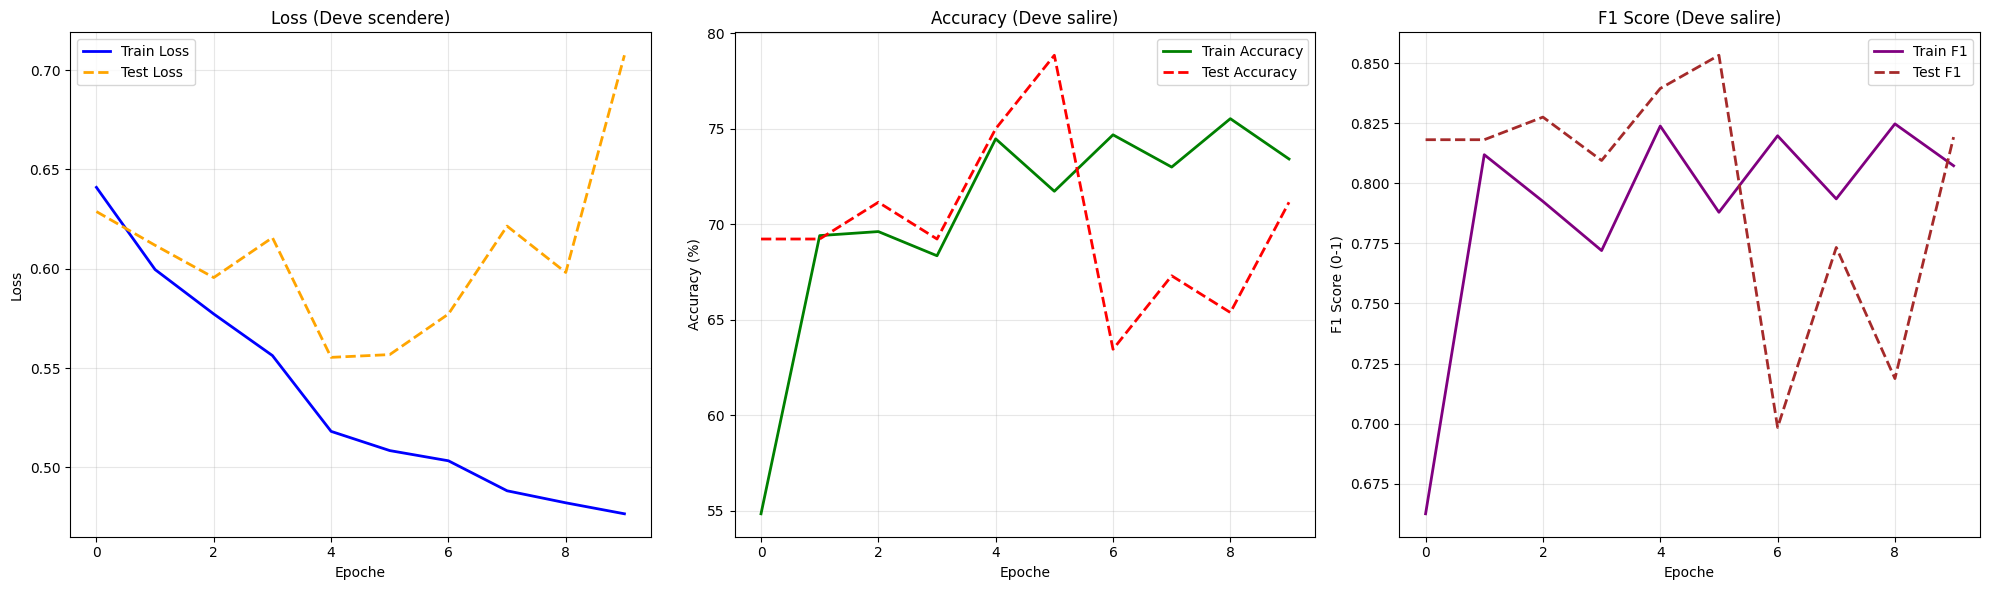

In [ ]:
import matplotlib.pyplot as plt

# Creiamo una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# --- Grafico 1: LOSS (Errore) ---
# Questo ci dice se il modello sta imparando (deve scendere)
axs[0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
axs[0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
axs[0].set_title('Loss (Deve scendere)')
axs[0].set_xlabel('Epoche')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# --- Grafico 2: ACCURACY ---
# Ci dice la percentuale totale di risposte corrette (deve salire)
axs[1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
axs[1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Accuracy (Deve salire)')
axs[1].set_xlabel('Epoche')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# --- Grafico 3: F1 SCORE ---
# Critico per dati sbilanciati o medici: media armonica tra precisione e recupero
axs[2].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
axs[2].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
axs[2].set_title('F1 Score (Deve salire)')
axs[2].set_xlabel('Epoche')
axs[2].set_ylabel('F1 Score (0-1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

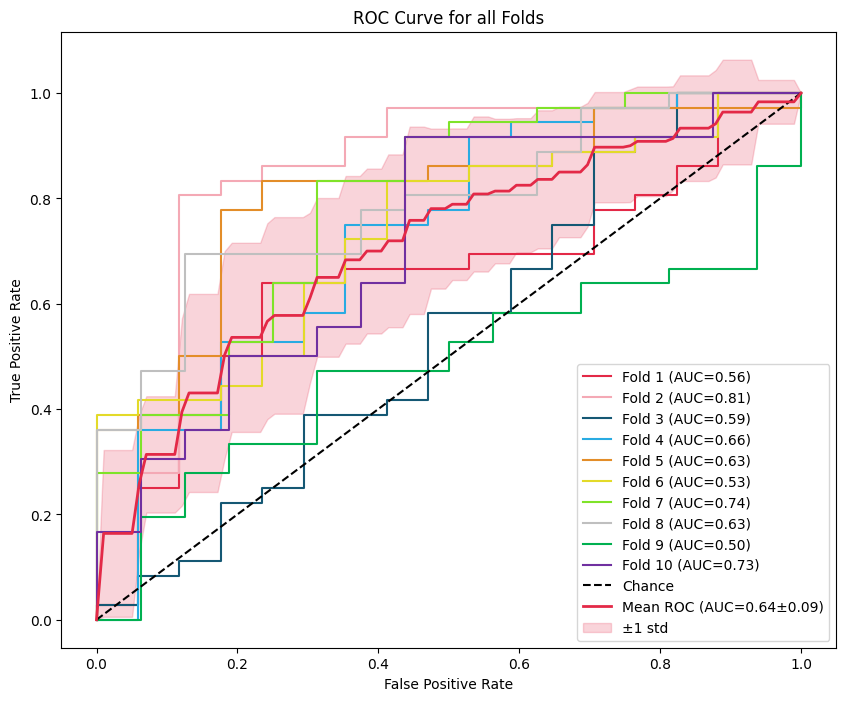

In [ ]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

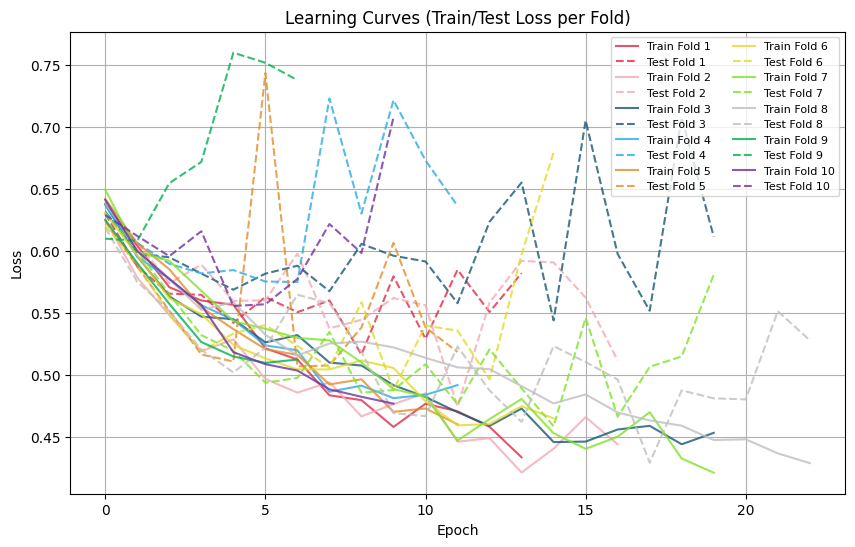

In [ ]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===
      Accuracy  F1 Score  Sensitivity (Recall)  Specificity     AUC
mean    0.7529    0.8414                0.9500       0.3261  0.6381
std     0.0453    0.0189                0.0520       0.2486  0.0994
min     0.6923    0.8182                0.8611       0.0000  0.5000
max     0.8302    0.8732                1.0000       0.7647  0.8129


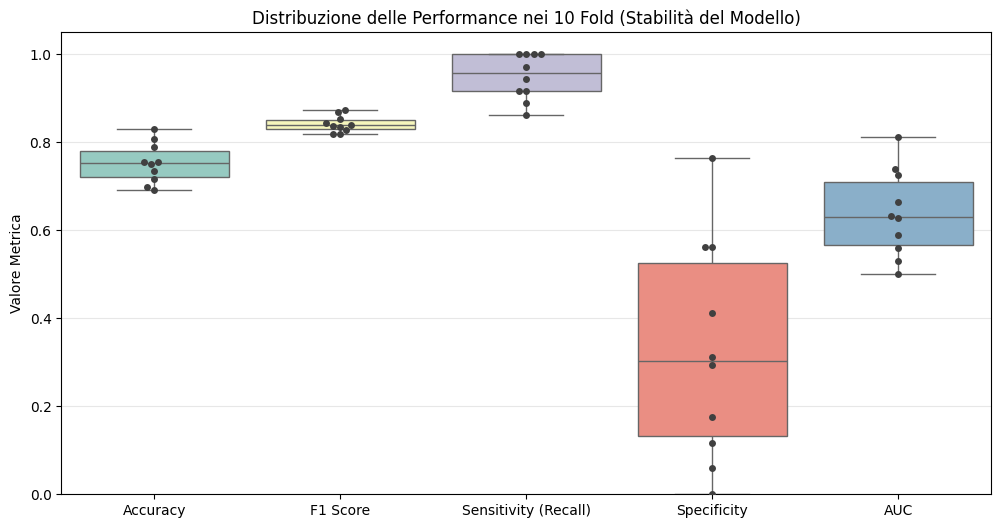

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Creazione di un DataFrame con tutti i risultati
results_data = {
    'Accuracy': np.array(accuracy_list_all_folds) / 100,  # <--- DIVISO PER 100
    'F1 Score': f1_list_all_folds,
    'Sensitivity (Recall)': sensitivity_list_all_folds,
    'Specificity': specificity_list_all_folds,
    'AUC': auc_score_list_all_folds
}

df_results = pd.DataFrame(results_data)

# 2. Calcolo delle Statistiche (Media e Deviazione Standard)
# La deviazione standard (std) ti dice quanto il modello è "instabile" tra un fold e l'altro
summary = df_results.describe().loc[['mean', 'std', 'min', 'max']]

print("=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===")
print(summary.round(4))

# 3. Visualizzazione Grafica (Boxplot)
# Questo grafico è fondamentale: la linea verde è la mediana, la scatola è dove cade il 50% dei casi.
# Se la scatola è molto "alta", il modello è instabile. Se è schiacciata, è molto robusto.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, palette="Set3")
sns.swarmplot(data=df_results, color=".25") # Aggiunge i punti reali per vedere la dispersione

plt.title('Distribuzione delle Performance nei 10 Fold (Stabilità del Modello)')
plt.ylabel('Valore Metrica')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.05) # Fissa l'asse Y tra 0 e 1 (o poco più per l'accuracy se è in %)
# Se l'accuracy è in scala 0-100, commenta la riga sopra o adattala a (0, 105)

plt.show();